# __Universidad Nacional Autónoma de México__
### POSGRADO EN CIENCIA E INGENIERÍA DE LA COMPUTACIÓN, ÁREA DE CÓMPUTO CIENTÍFICO

### ***SIMULACIÓN DE LA RESPUESTA DE UN DETECTOR DE CASCADAS ATMOSFÉRICAS EMPLEANDO REDES GENERATIVAS ANTAGÓNICAS CONDICIONALES***

### TRABAJO DE TESIS QUE PARA OBTENER EL GRADO DE: **MAESTRO EN CIENCIAS (COMPUTACIÓN)**

### PRESENTA: **J. EDUARDO MURRIETA L.**

### TUTOR: **Dr. LUKAS NELLEN**
***

### Créditos
El código de este notebook se basa en el modelo de red GAN del repositorio de Erik Linder-Norén, ingeniero de Machine Learning en Apple.

### Credits
The code in this notebook is based on the model of a GAN network form the repository of Erik Linder-Norén, engineer of Machine Learning at Apple.

Ref: https://github.com/eriklindernoren/PyTorch-GAN/blob/master/implementations/gan/gan.py
***

# I. Introducción
## HAWC
HAWC es un observatorio de agua y efecto Cherenkov a gran altura, diseñado para detectar rayos gamma y rayos cósmicos con energías entre 100 GeV y 100 TeV.

Se encuentra ubicado en una de las laderas del volcán Sierra Negra en Puebla a una altura de 4100 m sobre el nivel del mar.

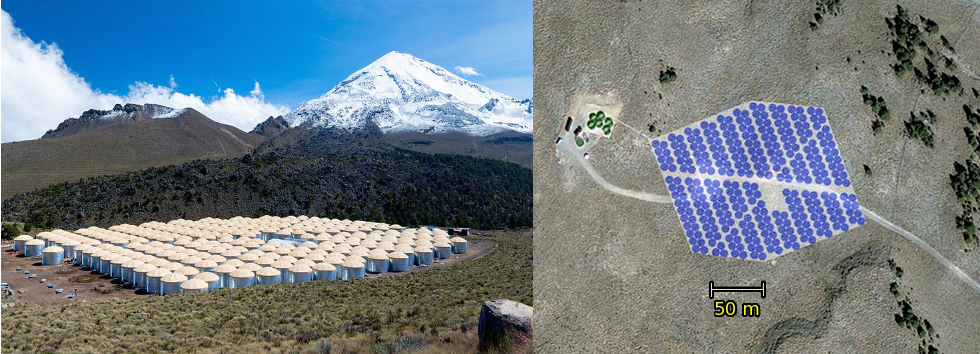

El Observatorio está compuesto por XXX tanques de agua con una altura de 4m y 7.3m de diámetro, cada uno cuenta con 4 Fotomultiplicadores PMT georeferenciados en el fondo del tanque.

Cuando un rayo cósmico o un rayo gamma ingresa a la atmósfera este interacciona con las moléculas a su paso y se producen subpartículas cargadas, generalmente piones, que alcanzan la superficie de la Tierra, a estos fenómenos se les denomina cascadas o chubascos atmosféricos.

Dependiendo del origen de la cascada, partícula o fotón, las dispersión de las partíulas secundarias generadas en la cascada tienen un patrón de distribución de la energía diferente.

Las cascadas de origen hadrónico (rayos cósmicos) poducen patrones más dispersos que los generados por fotones (rayos gamma) que tienden a concentrar la enrgía en una zona más definida.

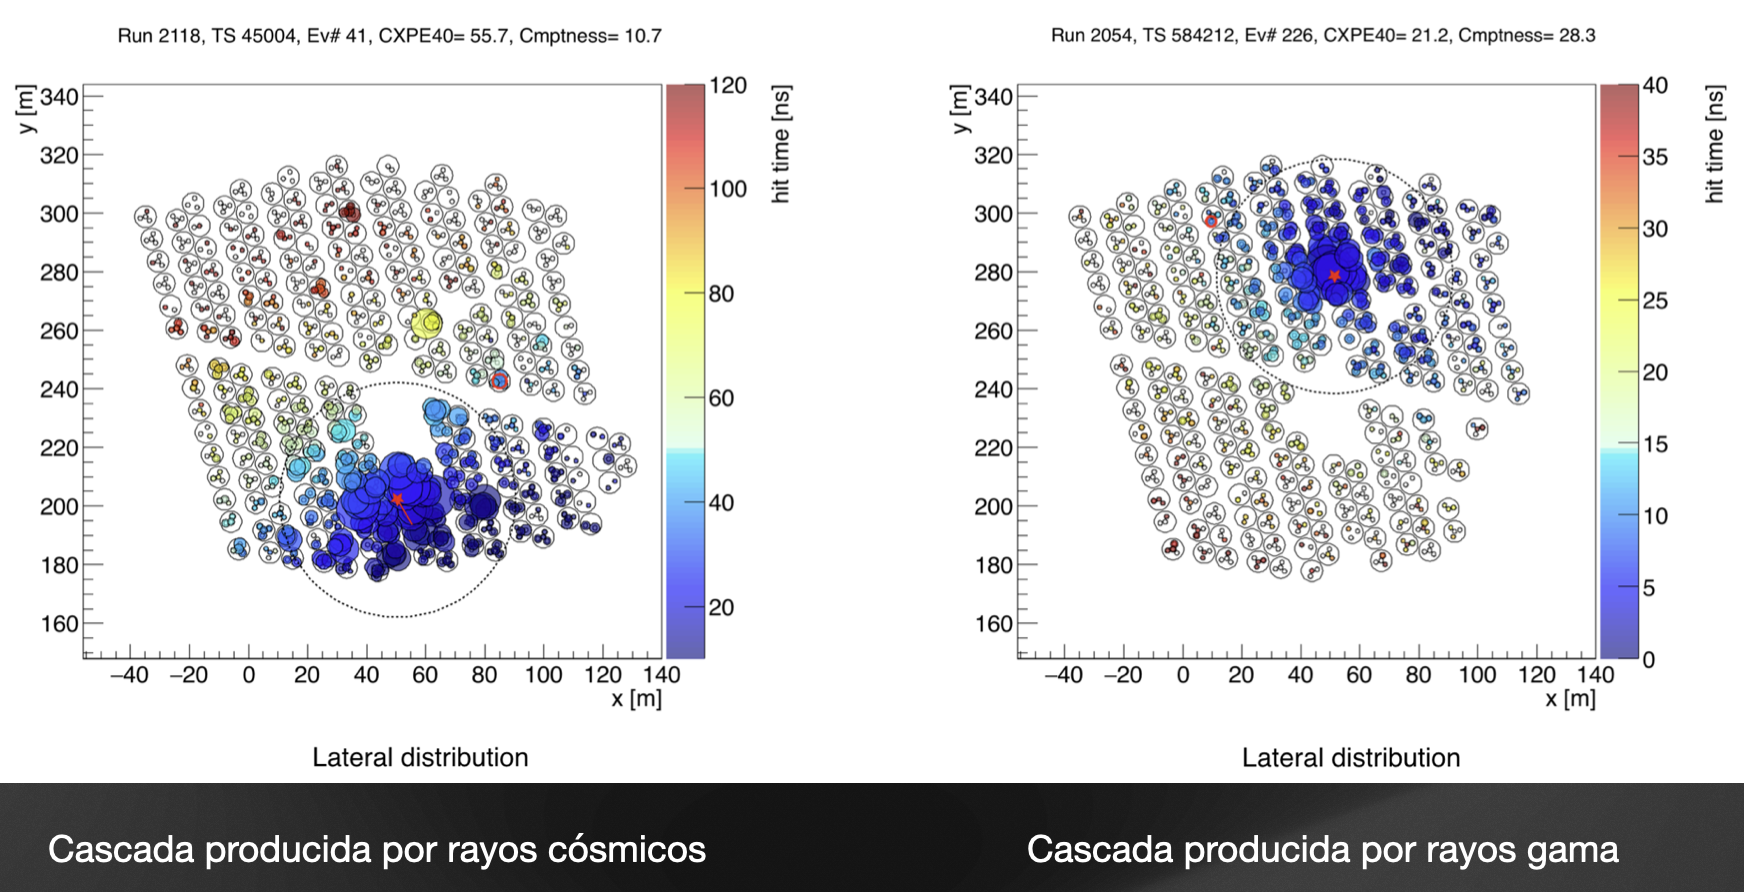

En este trabajo se implementa un modelo de Red Generativa Antagónica Condicinal (cGAN) entrenada a partir de mapas de calor que representan las concentraciones de energía medidas por los múltiples Foto-Multiplicadores PMT inmersos en los tanques de agua que conforman el Observatorio HAWC ante la incidencia de una Cascada Atmosférica. Estas mediciones son el resultado de simulaciones Montecarlo con CORSIKA-7 al nivel de la atmósfera y con GEANT4 a nivel del detector cuando las partículas de la cascada ingresan a los tanques e interactúan con la materia presente.

La parte condicional de la red cGAN emplea los siguientes parámetros que definen cada cascada que incide sobre el detector como condicionales del entrenamiento:

*  HAWCSim.Evt.Energy: Energía de la partícula primaria en GeV

*  HAWCSim.Evt.X, HAWCSim.Evt.Y: Posición del núcleo en coordenadas X,Y

*  HAWCSim.Evt.NMax: Ajuste del perfil longitudinal de la cascada en COSRIKA

*  HAWCSim.Evt.Theta: Ángulo con el zenit de la trayectoria princial

*  HAWCSim.Evt.Phi: Ángulo desde el eje X con la trayectoria principal

***


## Bibliotecas

In [29]:
# Bibliiotecas de ML
import torch
from   torch import nn
from   torch.autograd import Variable
import torchvision
import torchvision.transforms as transforms
from   sklearn.model_selection import train_test_split
from   scipy.stats import chisquare
from   skimage.metrics import structural_similarity as ssim
from   skimage.metrics import mean_squared_error
from   torchinfo import summary

In [54]:
# Bibliotecas de anális de datos
import pandas as pd
import matplotlib as mpl
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from scipy.stats import pearsonr 
import numpy as np
import os
import gc

# II. Parámetros del modelo

In [31]:
# Parámetros del modelo
n_classes=2         # clases de partículas: 0 -> Protones, 1-> Gamma
n_conditions=6+1    # total de condiciones de la red GAN
latent_dim=100      # dimensiones del espacio latente

In [32]:
# Parámetros de entrenamiento
lr = 0.0001            # Tasa de aprendizaje
n_epochs = 5000        # Total de épocas de entrenamiento
batch_size = 1000      # Tamaño del lote de entrenamiento
sample_interval = 100  # Período para muestreo del entrenamiento

In [33]:
# Limites de las condicionales usados para la normalización 
MaxEnergy={'proton':500000,'gamma':500000}
MaxN     ={'proton':5.2e+08,'gamma':5.2e+08}
MaxTheta ={'proton':65,'gamma':65}
MaxPhi   ={'proton':360,'gamma':360}
MaxXY    ={'X':39000,'Y':39000}

In [34]:
# Determina el dispositivo a usar en el entrenamiento
device = ""
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
if device.type=='cuda':
    print ('GPU Device')
else:
    print ('CPU Device')

GPU Device


### Control del entrenamiento

In [35]:
skip_train=True   # True: no realizar entrenamiento, False: realizar entrenamiento

# III. Datos de entrenamiento

Los datos de entrenamiento se encuentran bajo los directorios:

* hawc_image2/proton
* hawc_image2/gamma



In [36]:
#En caso de usar Google Drive para el acceso a los datos
#from google.colab import drive
#drive.mount('/content/drive')
#data_dir='/content/drive/MyDrive/Colab Notebooks/HAWC/hawc_image2'

#En caso de usar un directorio local
data_dir='hawc_image2'

hadrons=data_dir+'/proton/'
photons=data_dir+'/gamma/'
progress_dir='progress2'
! mkdir -p progress2/proton
! mkdir -p progress2/gamma

### Imagen muestra de los datos de entrenamiento

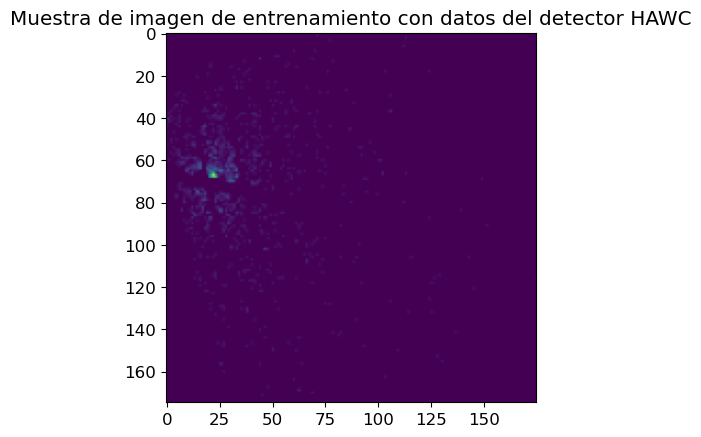

Image Size (175, 175, 4) 122500


In [37]:
particles=photons
sample_interval = 100
train_generator_skips=0
train_optimizer_skips=0
repeat_batches = 100

detector_data=os.listdir(particles)
img = mpimg.imread(particles+detector_data[25])
plt.imshow(img)
plt.title("Muestra de imagen de entrenamiento con datos del detector HAWC")
plt.show()
print(f'Image Size {img.shape}',img.size)

Por limitaciones de memoria la imgagen es reescalada a un formato de 150x150 pixeles, en tonos de gris.

### Transformaciones de la imagen para el entrenamiento.

In [38]:
img_shape = (1, 150, 150)
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Grayscale(),transforms.Resize(size=[150,150],antialias=True)] #,transforms.Normalize((0.5,), (0.5,))]
)

In [39]:
# Patch de torchvision.datasets.ImageFolder para incluir la ruta del archivo
# como parte de la tupla de retorno.
# Obtenida de: https://gist.github.com/andrewjong/6b02ff237533b3b2c554701fb53d5c4d
from torchvision import datasets

class ImageFolderWithPaths(datasets.ImageFolder):
    """Custom dataset that includes image file paths. Extends
    torchvision.datasets.ImageFolder
    """

    # override the __getitem__ method. this is the method that dataloader calls
    def __getitem__(self, index):
        # this is what ImageFolder normally returns 
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        # the image file path
        path = self.imgs[index][0]
        # make a new tuple that includes original and the path
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path


### Conjuntos de entrenamiento y prueba

In [40]:
full_set=ImageFolderWithPaths(data_dir,transform=transform)

train_set, test_set = train_test_split(full_set,
                                  test_size=0.2,  # => train: 0.8 DS, val: 0.2 DS
                                  shuffle=True)

### Definición del lote de trabajo.

In [41]:
train_dataloader = torch.utils.data.DataLoader(
    train_set, batch_size=batch_size, shuffle=True
)

test_dataloader = torch.utils.data.DataLoader(
    test_set, batch_size=int(batch_size/4), shuffle=True
)

# IV. Definición de la red cGAN

### Definición del Generador

In [42]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.label_emb = nn.Embedding(n_classes, n_classes)

        def block(in_feat, out_feat, normalize=True):
            layers = [nn.Linear(in_feat, out_feat)]
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            return layers

        self.model = nn.Sequential(
            *block(latent_dim + n_conditions, 256, normalize=True),
            *block(256, 512, normalize=True),
            *block(512, 1024, normalize=True),
            nn.Linear(1024, int(np.prod(img_shape))), 
            nn.Tanh()
        )

    def forward(self, noise, labels):
        gen_input = torch.cat((labels, noise), dim=-1)
        img = self.model(gen_input)
        img = img.view(img.size(0), *img_shape)
        return img

In [43]:
summary(Generator())

Layer (type:depth-idx)                   Param #
Generator                                --
├─Embedding: 1-1                         4
├─Sequential: 1-2                        --
│    └─Linear: 2-1                       27,648
│    └─LeakyReLU: 2-2                    --
│    └─BatchNorm1d: 2-3                  512
│    └─Linear: 2-4                       131,584
│    └─LeakyReLU: 2-5                    --
│    └─BatchNorm1d: 2-6                  1,024
│    └─Linear: 2-7                       525,312
│    └─LeakyReLU: 2-8                    --
│    └─BatchNorm1d: 2-9                  2,048
│    └─Linear: 2-10                      23,062,500
│    └─Tanh: 2-11                        --
Total params: 23,750,632
Trainable params: 23,750,632
Non-trainable params: 0

### Definición del Discriminador:

In [44]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.label_embedding = nn.Embedding(n_classes, n_conditions)

        self.model = nn.Sequential(
            nn.Linear(n_conditions + int(np.prod(img_shape)), 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 512),
            nn.LeakyReLU(0.2, inplace=True), #0.2 OK
            nn.Dropout(0.4),  # 0.4 OK
            nn.Linear(512, 512),
            nn.LeakyReLU(0.2, inplace=True), #0.2 OK
            nn.Dropout(0.4),  # 0.4 OK
            nn.Linear(512, 1),
            nn.Sigmoid(),
        )
    
    def forward(self, img, labels):
        d_in = torch.cat((img.view(img.size(0), -1), labels), -1)
        validity = self.model(d_in)
        return validity

In [45]:
summary(Discriminator())

Layer (type:depth-idx)                   Param #
Discriminator                            --
├─Embedding: 1-1                         14
├─Sequential: 1-2                        --
│    └─Linear: 2-1                       11,524,096
│    └─LeakyReLU: 2-2                    --
│    └─Linear: 2-3                       262,656
│    └─LeakyReLU: 2-4                    --
│    └─Dropout: 2-5                      --
│    └─Linear: 2-6                       262,656
│    └─LeakyReLU: 2-7                    --
│    └─Dropout: 2-8                      --
│    └─Linear: 2-9                       513
│    └─Sigmoid: 2-10                     --
Total params: 12,049,935
Trainable params: 12,049,935
Non-trainable params: 0

### Función de pérdida

In [46]:
adversarial_loss = torch.nn.BCELoss()

### Carga del modelo pre-entrenado si existe.

In [47]:
if os.path.isfile("HAWC_cGAN_GPU_final_checkpoint_generator_final.pt"):
    generator = torch.load("HAWC_cGAN_GPU_final_checkpoint_generator_final.pt") 
else:
    generator = Generator()
    
if os.path.isfile("HAWC_cGAN_GPU_final_checkpoint_discriminator_final.pt"):
    discriminator = torch.load("HAWC_cGAN_GPU_final_checkpoint_discriminator_final.pt")
else:
    discriminator = Discriminator()    

if device.type=='cuda':
    generator.cuda()
    discriminator.cuda()
    adversarial_loss.cuda()

### Definición de los optimizadores para el Generador y Discriminador

In [48]:
b1=0.5      
b2=0.999    
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(b1, b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(b1, b2))

FloatTensor = torch.cuda.FloatTensor if device.type=='cuda' else torch.FloatTensor
LongTensor  = torch.cuda.LongTensor  if device.type=='cuda' else torch.LongTensor

# V. Entrenamiento del modelo

### Función para guardar el progreso del entrenamiento

In [49]:
def sample_image(n_row, batches_done,images,labels,chi2,simage):
    """Saves a grid of generated digits ranging from 0 to n_classes"""
    bbox_inches=mpl.transforms.Bbox([[1.5, 0.55 ], [5, 4.05]])

    plt.ioff()
    part1=False
    part2=False

    for idx in range(images.shape[0]):
        generated_samples = images.detach()[idx,0]
        generated_samples = generated_samples.to('cpu')
        plot=(generated_samples.numpy())

        if labels[idx][0]==0 and part1==False:
           particle = 'hadron'
           part1=True
        elif labels[idx][0]==1 and part2==False:
           particle = 'gamma'
           part2=True
        elif part1 and part2:
           break
        else:
            continue
        
        plt.imshow(plot,  origin='upper')
        image_path=progress_dir+f'/{particle}/cGAN_progress_{particle}_{latent_dim}_{batches_done}_chi2-{chi2:0.2}_ssim-{simage:0.2}.png'
        plt.savefig(image_path, dpi=50, bbox_inches=bbox_inches)


### Ciclo de entrenamiento de la cGAN

In [50]:
from scipy.stats import chisquare
def cs(n, y):
    return chisquare(n, np.sum(n)/np.sum(y) * y)

In [51]:
best_ssimage = -1  

for epoch in range(n_epochs):
    # breaks the loop if no train is needed
    if skip_train:
        break     # Do not train
        
    for i, (imgs, labels, paths) in enumerate(train_dataloader):

        batch_size = imgs.shape[0]
        np_meta = np.array([])
        for path in paths:
            path=path.replace('hawc_image','hawc_meta').replace('.png','.csv')
            if os.path.isfile(path):
                metadf = pd.read_csv(path)
                metadf['HAWCSim.Evt.Energy/F/0']=metadf['HAWCSim.Evt.Energy/F/0']/MaxEnergy['proton']
                metadf['HAWCSim.Evt.X/F/0.01']=metadf['HAWCSim.Evt.X/F/0.01']/MaxXY['X']
                metadf['HAWCSim.Evt.Y/F/0.01']=metadf['HAWCSim.Evt.Y/F/0.01']/MaxXY['Y']
                metadf['HAWCSim.Evt.NMax/F/0.001']=metadf['HAWCSim.Evt.NMax/F/0.001']/MaxN['proton']
                metadf['HAWCSim.Evt.Theta/F/0.001']=metadf['HAWCSim.Evt.Theta/F/0.001']/MaxTheta['proton']
                metadf['HAWCSim.Evt.Phi/F/0.001']=metadf['HAWCSim.Evt.Phi/F/0.001']/MaxPhi['proton']
                np_meta= np.append(np_meta,metadf.to_numpy())
                del metadf
            else:
                np_meta= np.append(np_meta,[0.,0.,0.,0.,0.,0.])
        
        # Adversarial ground truths
        valid = Variable(FloatTensor(batch_size, 1).fill_(1.0), requires_grad=False)
        fake  = Variable(FloatTensor(batch_size, 1).fill_(0.0), requires_grad=False)

        # Configure input
        real_imgs = Variable(imgs.type(FloatTensor))
        
        labels = Variable(torch.cat(
                          (labels.type(LongTensor).reshape(batch_size,1),
                           FloatTensor(np_meta).reshape(batch_size,n_conditions-1)),
                           1
                         ))

        for _ in range(repeat_batches):
            # -----------------
            #  Train Generator
            # -----------------
            skip_train_generator=train_generator_skips
            optimizer_G.zero_grad()

            # Sample noise and labels as generator input
            z = Variable(FloatTensor(np.random.normal(0, 1, (batch_size, latent_dim))))      

            gen_imgs = generator(z, labels)

            # Loss measures generator's ability to fool the discriminator
            validity = discriminator(gen_imgs, labels)
            g_loss = adversarial_loss(validity, valid)

            g_loss.backward()
            optimizer_G.step()
        

            # ---------------------
            #  Train Discriminator
            # ---------------------
        
            skip_train_optimizer=train_optimizer_skips
            optimizer_D.zero_grad()

            # Loss for real images
            validity_real = discriminator(real_imgs, labels)
            d_real_loss = adversarial_loss(validity_real, valid)

            # Loss for fake images
            validity_fake = discriminator(gen_imgs.detach(), labels)
            d_fake_loss = adversarial_loss(validity_fake, fake)
 
            # Total discriminator loss
            d_loss = (d_real_loss + d_fake_loss) / 2

            d_loss.backward()
            optimizer_D.step()

        batches_done = epoch * len(train_dataloader) + i
        if batches_done % sample_interval == 0:
            sum_simage=0
            real_imgs_cpu=real_imgs.detach().cpu().numpy()
            gen_imgs_cpu = gen_imgs.detach().cpu().numpy()
            
            schi2=0
            for idx in range(real_imgs.shape[0]):
                bins=np.linspace(0,0.7,30)
                img_np = np.abs(imgs.numpy()[idx][0])
                gen_img_np = np.abs(gen_imgs_cpu[idx].reshape((150,150)))
                countsRef,binsRef=np.histogram(img_np.reshape(150*150),bins=bins)
                countsGen,binsGen=np.histogram(gen_img_np.reshape(150*150),bins=bins)
                
                chi2,p_value= cs(countsGen+1,countsRef+1)
                schi2+=chi2            
                simage = ssim(gen_img_np,img_np,data_range=img_np.max()-img_np.min())
                sum_simage+=simage

            ssimage = sum_simage/real_imgs.shape[0]
            
            print(
                f'[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f] [chi^2: %g] [SSIM: %g]'
                % (epoch, n_epochs, i, len(train_dataloader), d_loss.item(), g_loss.item(),chi2,ssimage)
            )
            sample_image(n_row=n_classes, batches_done=batches_done,images=gen_imgs,labels=labels,
                        chi2=chi2,simage=ssimage)
            
            if ssimage > best_ssimage:
                best_ssimage=ssimage                
                print('---------------------------------------------------------------------------')
                print (f'Saving best model: SSIM: {ssimage:0.2}')
                torch.save(generator,"HAWC_cGAN_GPU_final_checkpoint_generator.pt") 
                torch.save(discriminator,"HAWC_cGAN_GPU_final_checkpoint_discriminator.pt")
                print('---------------------------------------------------------------------------')

### Guarda el estado final del modelo

In [52]:
if not skip_train:
    torch.save(generator,"HAWC_cGAN_GPU_final_checkpoint_generator_final.pt") 
    torch.save(discriminator,"HAWC_cGAN_GPU_final_checkpoint_discriminator_final.pt")

----------------------------------------------

# Evaluación con el conjunto de prueba

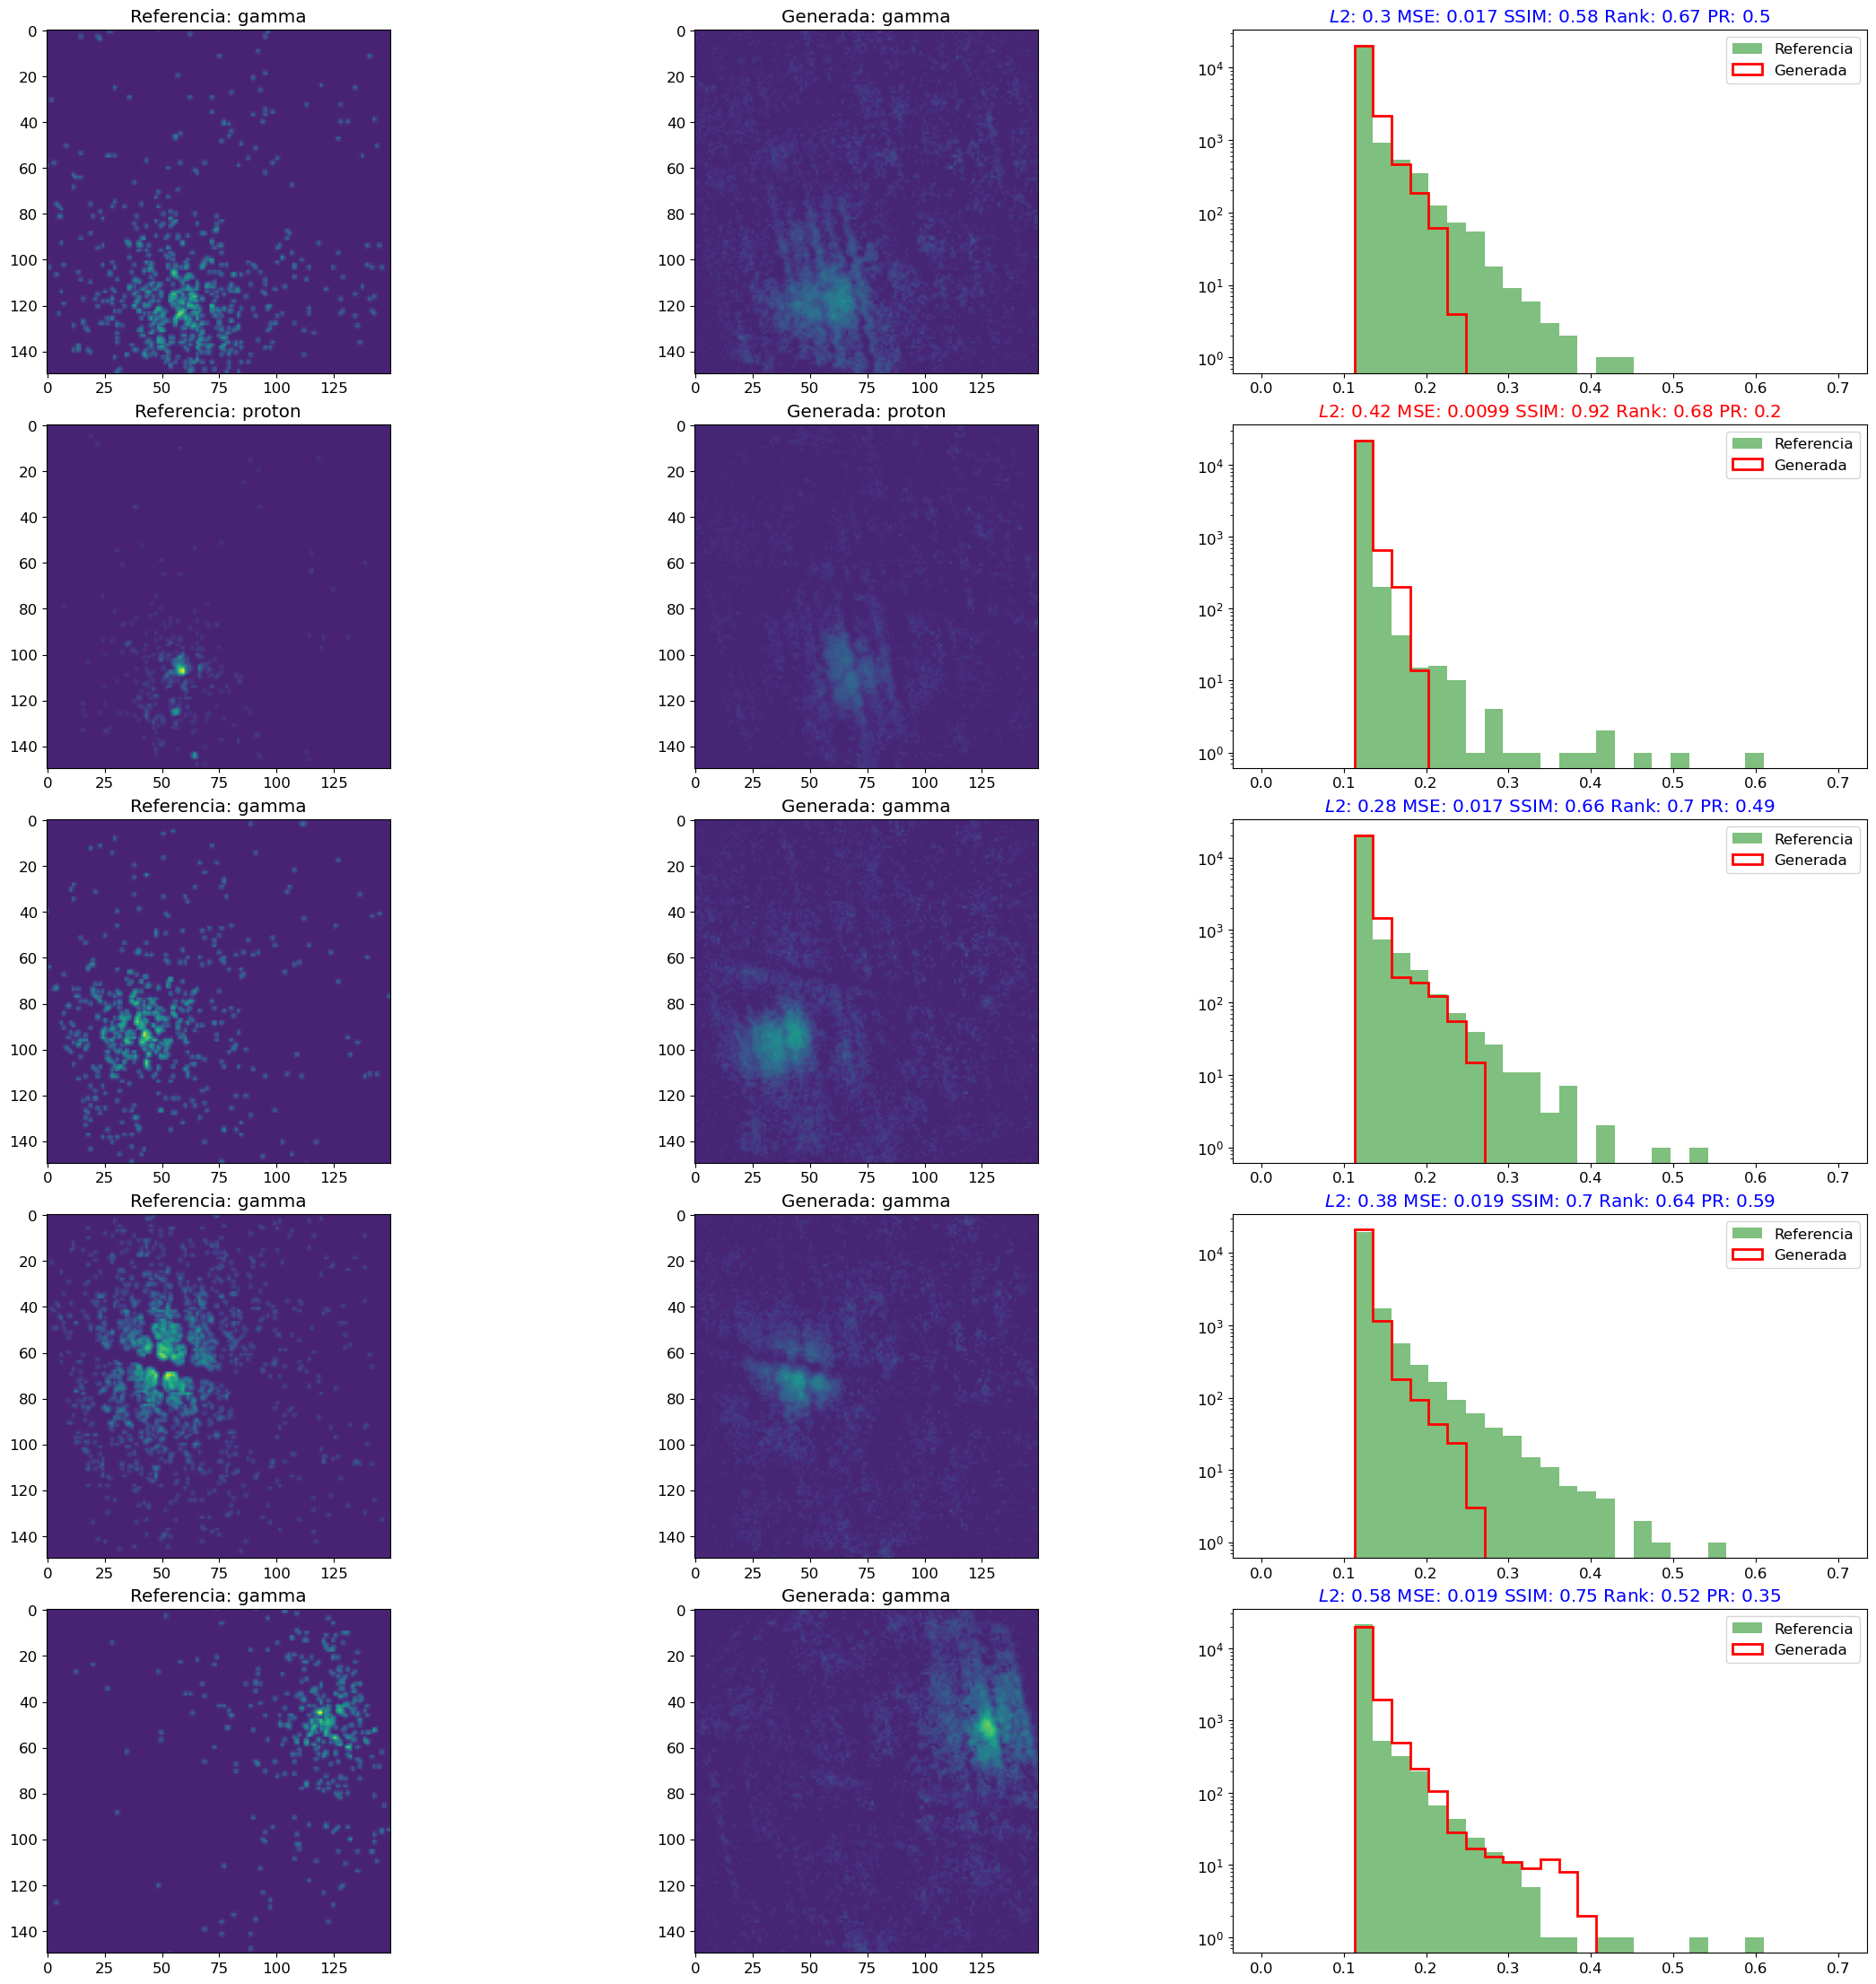

In [83]:
from scipy.stats import chisquare
plt.rcParams['text.usetex']=False
plt.ion()
plt.rcParams.update({'font.size':12})
for i, (imgs, labels, paths) in enumerate(test_dataloader):

        batch_size = imgs.shape[0]
    
        np_meta = np.array([])
        for path in paths:
            path=path.replace('hawc_image','hawc_meta').replace('.png','.csv')
            if os.path.isfile(path):
                metadf = pd.read_csv(path)
                metadf['HAWCSim.Evt.Energy/F/0']=metadf['HAWCSim.Evt.Energy/F/0']/MaxEnergy['proton']
                metadf['HAWCSim.Evt.X/F/0.01']=metadf['HAWCSim.Evt.X/F/0.01']/MaxXY['X']
                metadf['HAWCSim.Evt.Y/F/0.01']=metadf['HAWCSim.Evt.Y/F/0.01']/MaxXY['Y']
                metadf['HAWCSim.Evt.NMax/F/0.001']=metadf['HAWCSim.Evt.NMax/F/0.001']/MaxN['proton']
                metadf['HAWCSim.Evt.Theta/F/0.001']=metadf['HAWCSim.Evt.Theta/F/0.001']/MaxTheta['proton']
                metadf['HAWCSim.Evt.Phi/F/0.001']=metadf['HAWCSim.Evt.Phi/F/0.001']/MaxPhi['proton']
                np_meta= np.append(np_meta,metadf.to_numpy())
                del metadf
            else:
                np_meta= np.append(np_meta,[0.,0.,0.,0.,0.,0.])
                
        # Sample noise and labels as generator input
        optimizer_G.zero_grad()
    
        z = Variable(FloatTensor(np.random.normal(0, 1, (batch_size, latent_dim))))

        # Tratamos de generar una respuesta similar al entrenamiento
        gen_labels = Variable(torch.cat(
                          (labels.type(LongTensor).reshape(batch_size,1),
                           FloatTensor(np_meta).reshape(batch_size,n_conditions-1)),
                           1))
        
        gen_imgs = generator(z, gen_labels)

        fig,axes = plt.subplots(nrows=5,ncols=3,figsize=(22,22),constrained_layout=True)
        
        for idx in range(5): 
            generated_samples = gen_imgs.detach()[idx,0]
            generated_samples = generated_samples.to('cpu')
            plot=(generated_samples.numpy()).reshape(150*150)
            plot=np.array([ plot[i] if plot[i]>=0.12 else 0.12 for i in range(150*150) ]).reshape([150,150])
            
            if gen_labels[idx][0]==0:
                particle = 'gamma'
            else:
                particle = 'proton'

            alpha=1.0
            
            axes[idx,1].imshow(np.abs(plot)*alpha, norm='log', origin='upper', vmin=0.1,vmax=0.6)
            axes[idx,1].set_title(f'Generada: {particle}')

            # Comparamos con la imagen de entrenamiento
            if labels[idx]==0:
                particle = 'gamma'
            else:
                particle = 'proton'

            axes[idx,0].imshow(np.abs(imgs.numpy()[idx][0]),  norm='log', origin='upper', vmin=0.1,vmax=0.6)
            axes[idx,0].set_title(f'Referencia: {particle}')

            BINS=32
            bins=np.linspace(0,0.7,BINS)
            countsRef,binsRef=np.histogram(imgs.numpy()[idx][0].reshape(150*150),bins=bins)
            countsGen,binsGen=np.histogram(plot.reshape(150*150)*alpha,bins=bins)
            
            axes[idx,2].hist(binsRef[:-1],binsRef,weights=countsRef,log=True,label='Referencia',color='g',alpha=0.5)
            axes[idx,2].hist(binsGen[:-1],binsGen,weights=countsGen,log=True,histtype='step',stacked=True,label='Generada',color='r',linewidth=2)
            
            chi2,p_value= cs(countsGen+1,countsRef+1)
            img_np = np.abs(imgs.numpy()[idx][0])

            L2=np.sum(np.abs(countsGen-countsRef)/np.abs(countsRef+1))/BINS

            simage = ssim(plot,img_np,data_range=img_np.max()-img_np.min())
            mse= np.sqrt(np.square(np.subtract(plot.reshape(150*150),img_np.reshape(150*150))).mean())
            s=f'{L2:0.2}'
            
            rank=(1-L2)*0.7+simage*0.3

            corrCoef, p_value = pearsonr(imgs.numpy()[idx][0].reshape(150*150), 
                                        plot.reshape(150*150)*alpha)
            
            if  corrCoef>=0.3: #rank>=0.65:    
                axes[idx,2].set_title(f'$L2$: '+s+f' MSE: {mse:0.2} SSIM: {simage:0.2} Rank: {rank:0.2} PR: {corrCoef:0.2}',color='b')
            else:
                axes[idx,2].set_title(f'$L2$: '+s+f' MSE: {mse:0.2} SSIM: {simage:0.2} Rank: {rank:0.2} PR: {corrCoef:0.2}',color='r')
            
            axes[idx,2].legend(loc='upper right')
        break
    


# Rendimiento del conjunto de prueba

Count 2820 Efficiency: 0.62


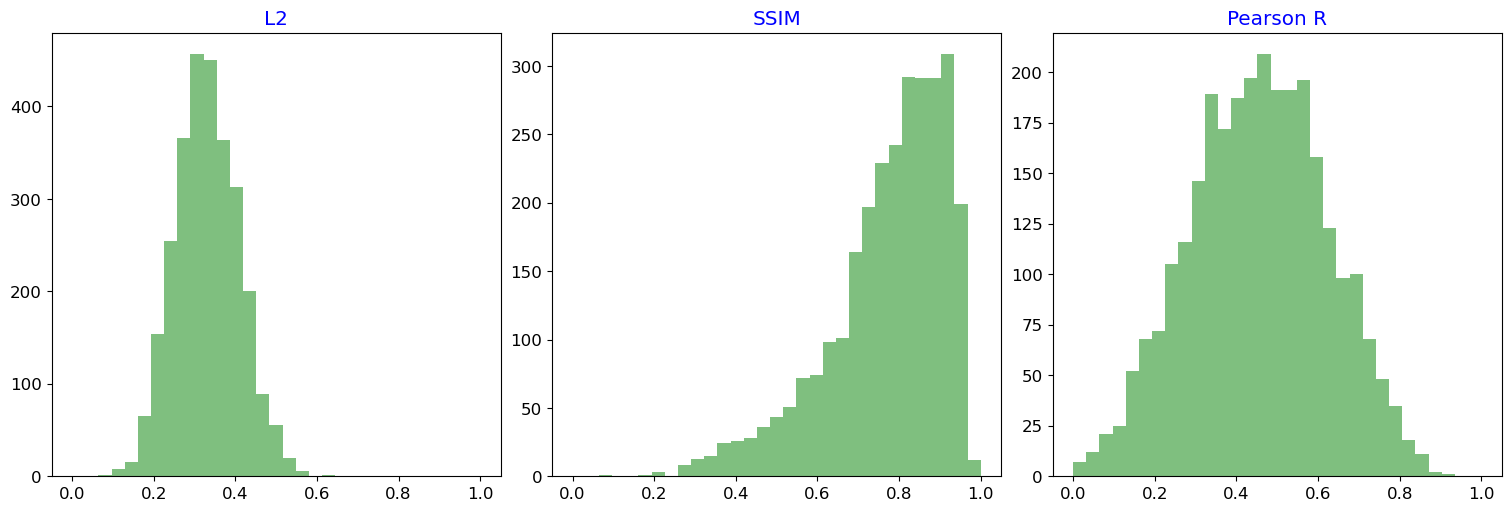

In [95]:
from scipy.stats import chisquare
plt.rcParams['text.usetex']=False
plt.ion()
plt.rcParams.update({'font.size':12})

ssimage_metrics=np.array([])
mse_metrics=np.array([])
L2_metrics=np.array([])
R_metrics=np.array([])
rank_metrics=np.array([])

eff=0
count=0

for i, (imgs, labels, paths) in enumerate(test_dataloader):

        batch_size = imgs.shape[0]
    
        np_meta = np.array([])
        for path in paths:
            path=path.replace('hawc_image','hawc_meta').replace('.png','.csv')
            if os.path.isfile(path):
                metadf = pd.read_csv(path)
                metadf['HAWCSim.Evt.Energy/F/0']=metadf['HAWCSim.Evt.Energy/F/0']/MaxEnergy['proton']
                metadf['HAWCSim.Evt.X/F/0.01']=metadf['HAWCSim.Evt.X/F/0.01']/MaxXY['X']
                metadf['HAWCSim.Evt.Y/F/0.01']=metadf['HAWCSim.Evt.Y/F/0.01']/MaxXY['Y']
                metadf['HAWCSim.Evt.NMax/F/0.001']=metadf['HAWCSim.Evt.NMax/F/0.001']/MaxN['proton']
                metadf['HAWCSim.Evt.Theta/F/0.001']=metadf['HAWCSim.Evt.Theta/F/0.001']/MaxTheta['proton']
                metadf['HAWCSim.Evt.Phi/F/0.001']=metadf['HAWCSim.Evt.Phi/F/0.001']/MaxPhi['proton']
                np_meta= np.append(np_meta,metadf.to_numpy())
                del metadf
            else:
                np_meta= np.append(np_meta,[0.,0.,0.,0.,0.,0.])
                
        optimizer_G.zero_grad()
    
        z = Variable(FloatTensor(np.random.normal(0, 1, (batch_size, latent_dim))))
        z = Variable(FloatTensor(np.random.normal(0, 1, (batch_size, latent_dim))))

        # Tratamos de generar una respuesta similar al entrenamiento
        gen_labels = Variable(torch.cat(
                          (labels.type(LongTensor).reshape(batch_size,1),
                           FloatTensor(np_meta).reshape(batch_size,n_conditions-1)),
                           1))
        
        gen_imgs = generator(z, gen_labels)

        for idx in range(batch_size):
            generated_samples = gen_imgs.detach()[idx,0]
            generated_samples = generated_samples.to('cpu')
            plot=(generated_samples.numpy()).reshape(150*150)
            plot=np.array([ plot[i] if plot[i]>=0.12 else 0.12 for i in range(150*150) ]).reshape([150,150])
            
            if gen_labels[idx][0]==0:
                particle = 'gamma'
            else:
                particle = 'proton'

            alpha=1.0
            #Visualizamos la imagen generada

            # Comparamos con la imagen de entrenamiento
            if labels[idx]==0:
                particle = 'gamma'
            else:
                particle = 'proton'

            BINS=30
            bins=np.linspace(0,0.7,BINS)
            img_np = np.abs(imgs.numpy()[idx][0])
            
            countsRef,binsRef=np.histogram(img_np.reshape(150*150),bins=bins)
            countsGen,binsGen=np.histogram(plot.reshape(150*150)*alpha,bins=bins)
            
            chi2,p_value= cs(countsGen+1,countsRef+1)
            chi2=chi2/(BINS-1)

            L2=np.sum(np.abs(countsGen-countsRef)/np.abs(np.maximum(countsGen,countsRef)+1))/BINS
            
            simage = ssim(plot,img_np,data_range=img_np.max()-img_np.min())
            mse=np.sqrt(np.square(np.subtract(plot.reshape(150*150),img_np.reshape(150*150))).mean())
            rank=(1-L2)*0.7+simage*0.3
            #if rank>=0.65:
            #    eff=eff+1
            #count=count+1

            corrCoef, p_value = pearsonr(np.abs(img_np.reshape(150*150)), 
                                         np.abs(plot.reshape(150*150)))

            if corrCoef>=0.4:
                eff=eff+1
            count=count+1
            
            L2_metrics=np.append(L2_metrics,L2)
            R_metrics=np.append(R_metrics,corrCoef)
            ssimage_metrics=np.append(ssimage_metrics,simage)
            mse_metrics=np.append(mse_metrics,mse)
            rank_metrics=np.append(rank_metrics,rank)


fig,axes = plt.subplots(nrows=1,ncols=3,figsize=(15,5),constrained_layout=True)

BINS=32
bins=np.linspace(0,1,BINS)
counts,bins_tmp=np.histogram(L2_metrics,bins=bins)
axes[0].hist(bins_tmp[:-1],bins_tmp,weights=counts,log=False,label='L2',color='g',alpha=0.5)
axes[0].set_title(f'L2',color='b')

bins=np.linspace(0,1,BINS)
counts,bins_tmp=np.histogram(ssimage_metrics,bins=bins)
axes[1].hist(bins_tmp[:-1],bins_tmp,weights=counts,log=False,label='SSIMAGE',color='g',alpha=0.5)
axes[1].set_title(f'SSIM',color='b')

bins=np.linspace(0,1,BINS)
counts,bins_tmp=np.histogram(R_metrics,bins=bins)
axes[2].hist(bins_tmp[:-1],bins_tmp,weights=counts,log=False,label='Rank',color='g',alpha=0.5)
axes[2].set_title(f'Pearson R',color='b')

print (f'Count {count} Efficiency: {eff/count:0.2}')


----------------------------------------
# Variantes con las mismas condiciones iniciales
----------------------------------------

no metadata


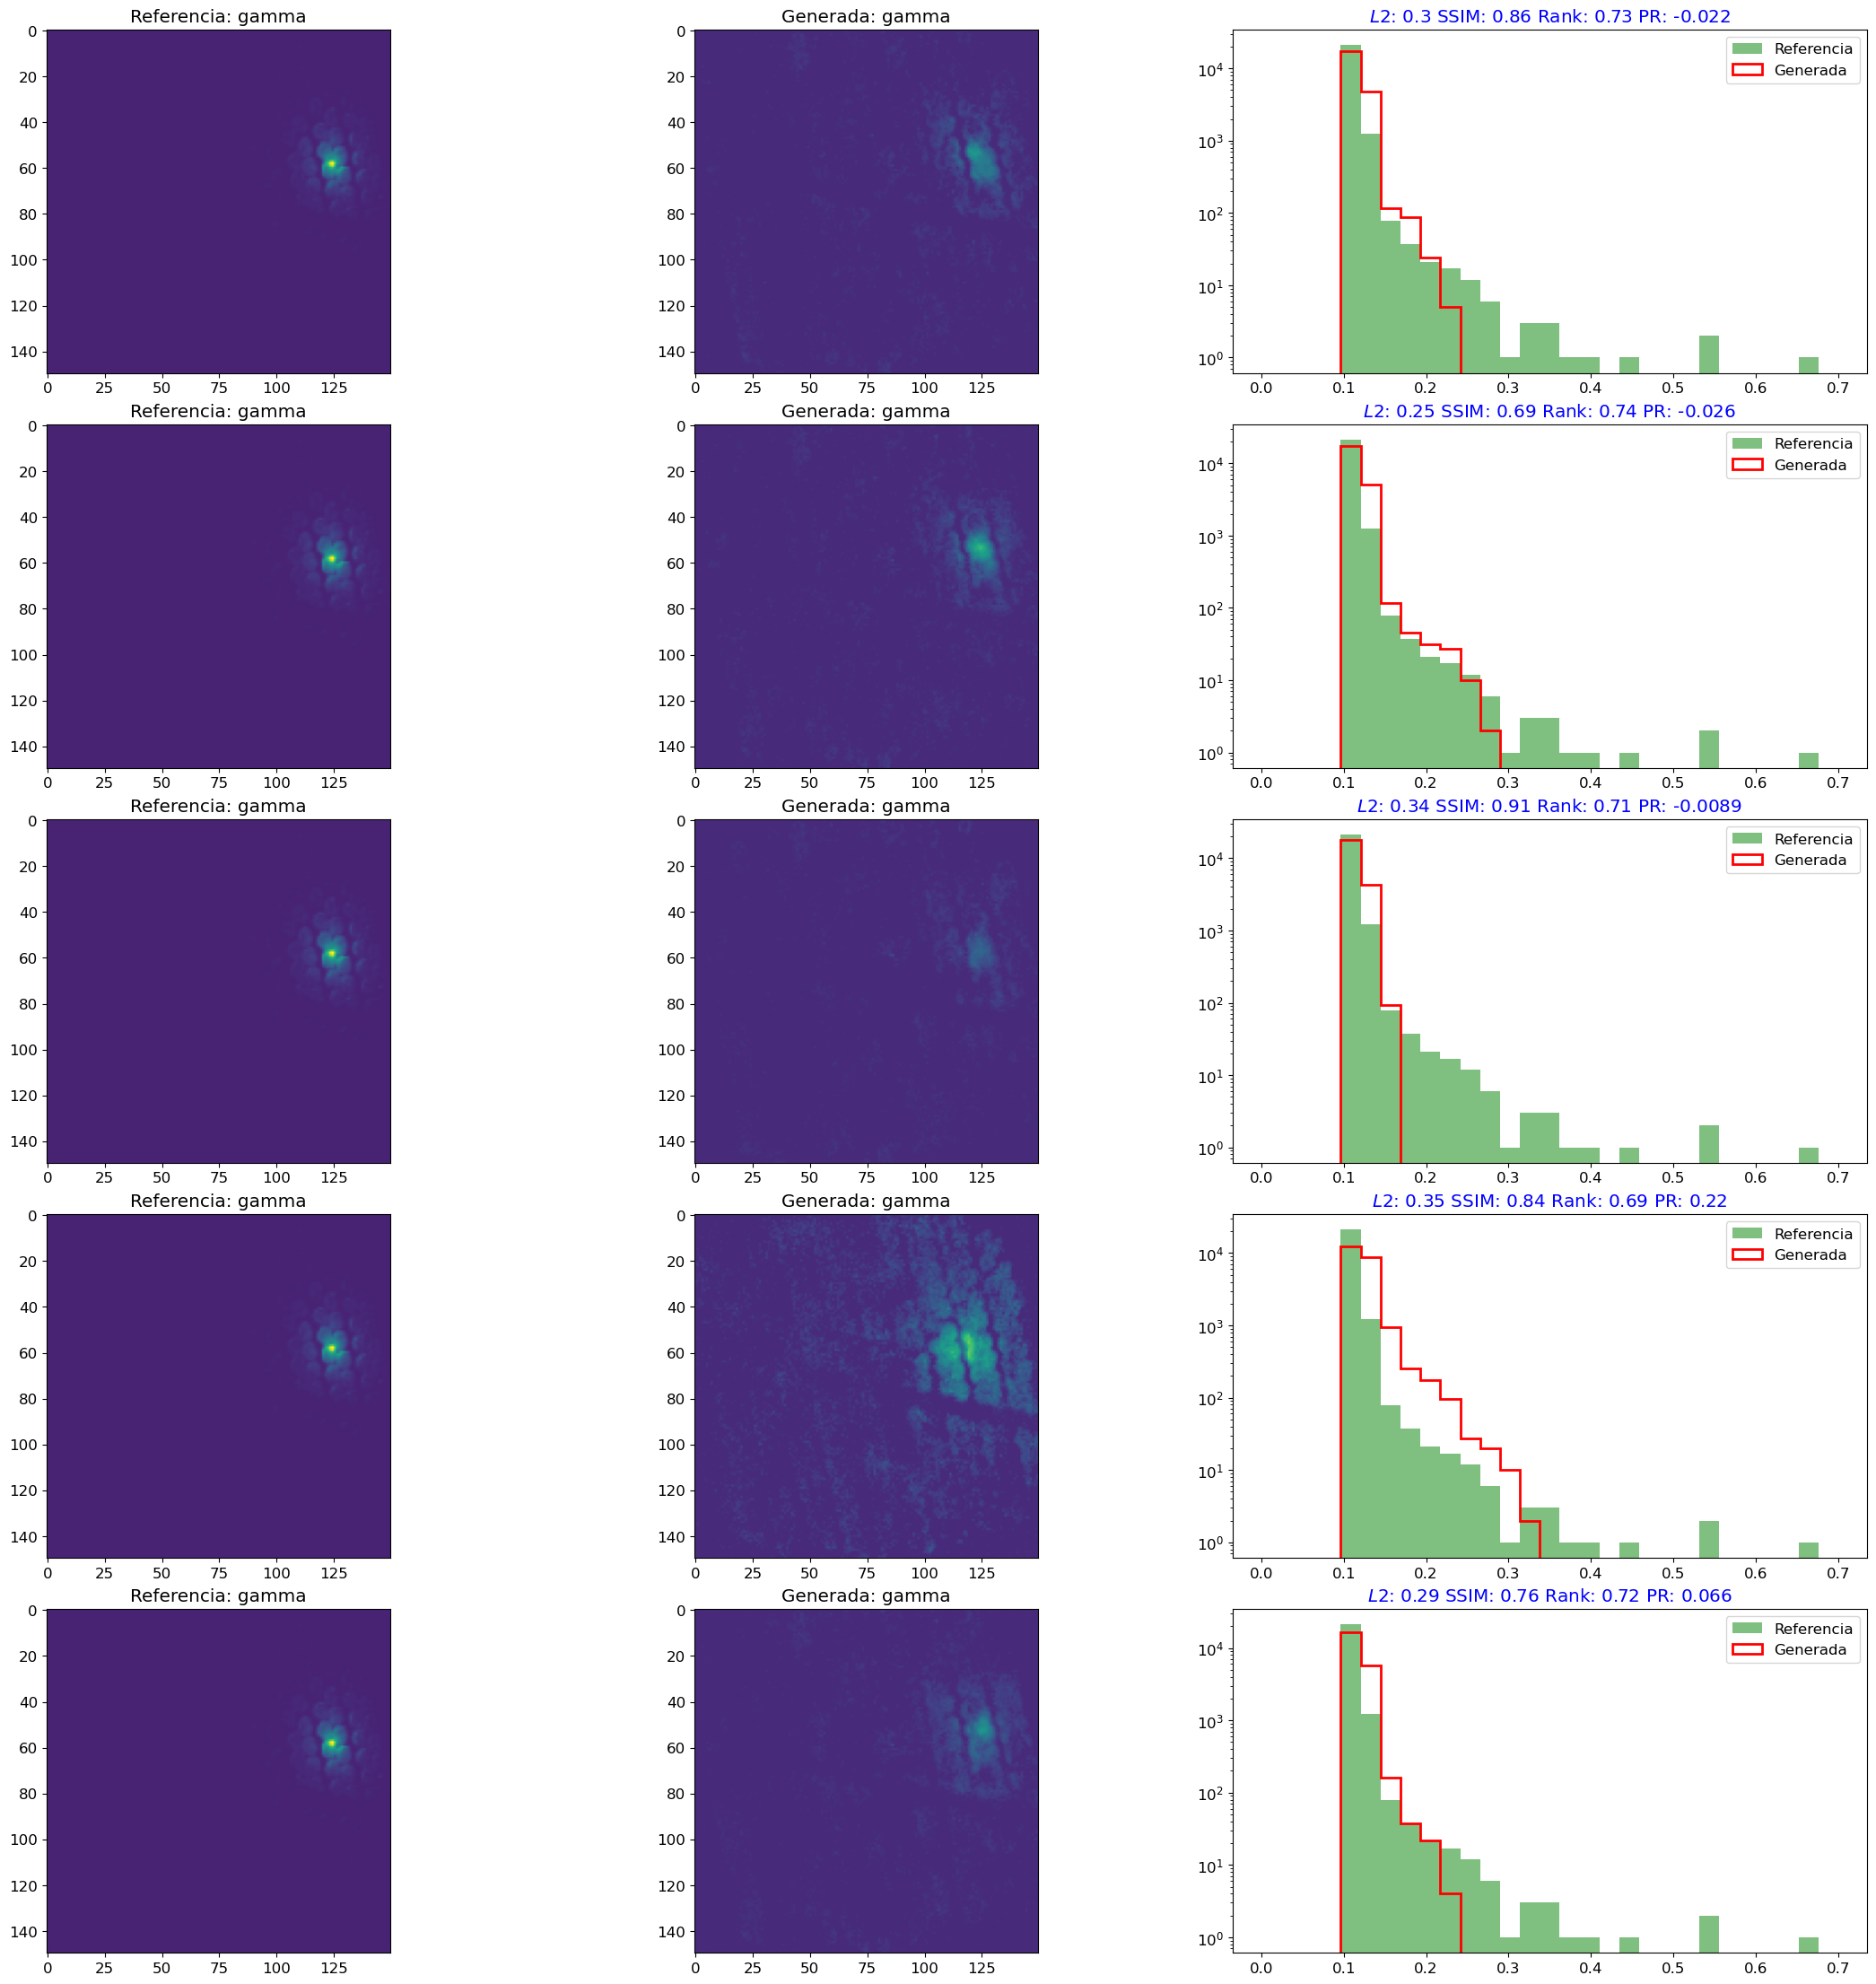

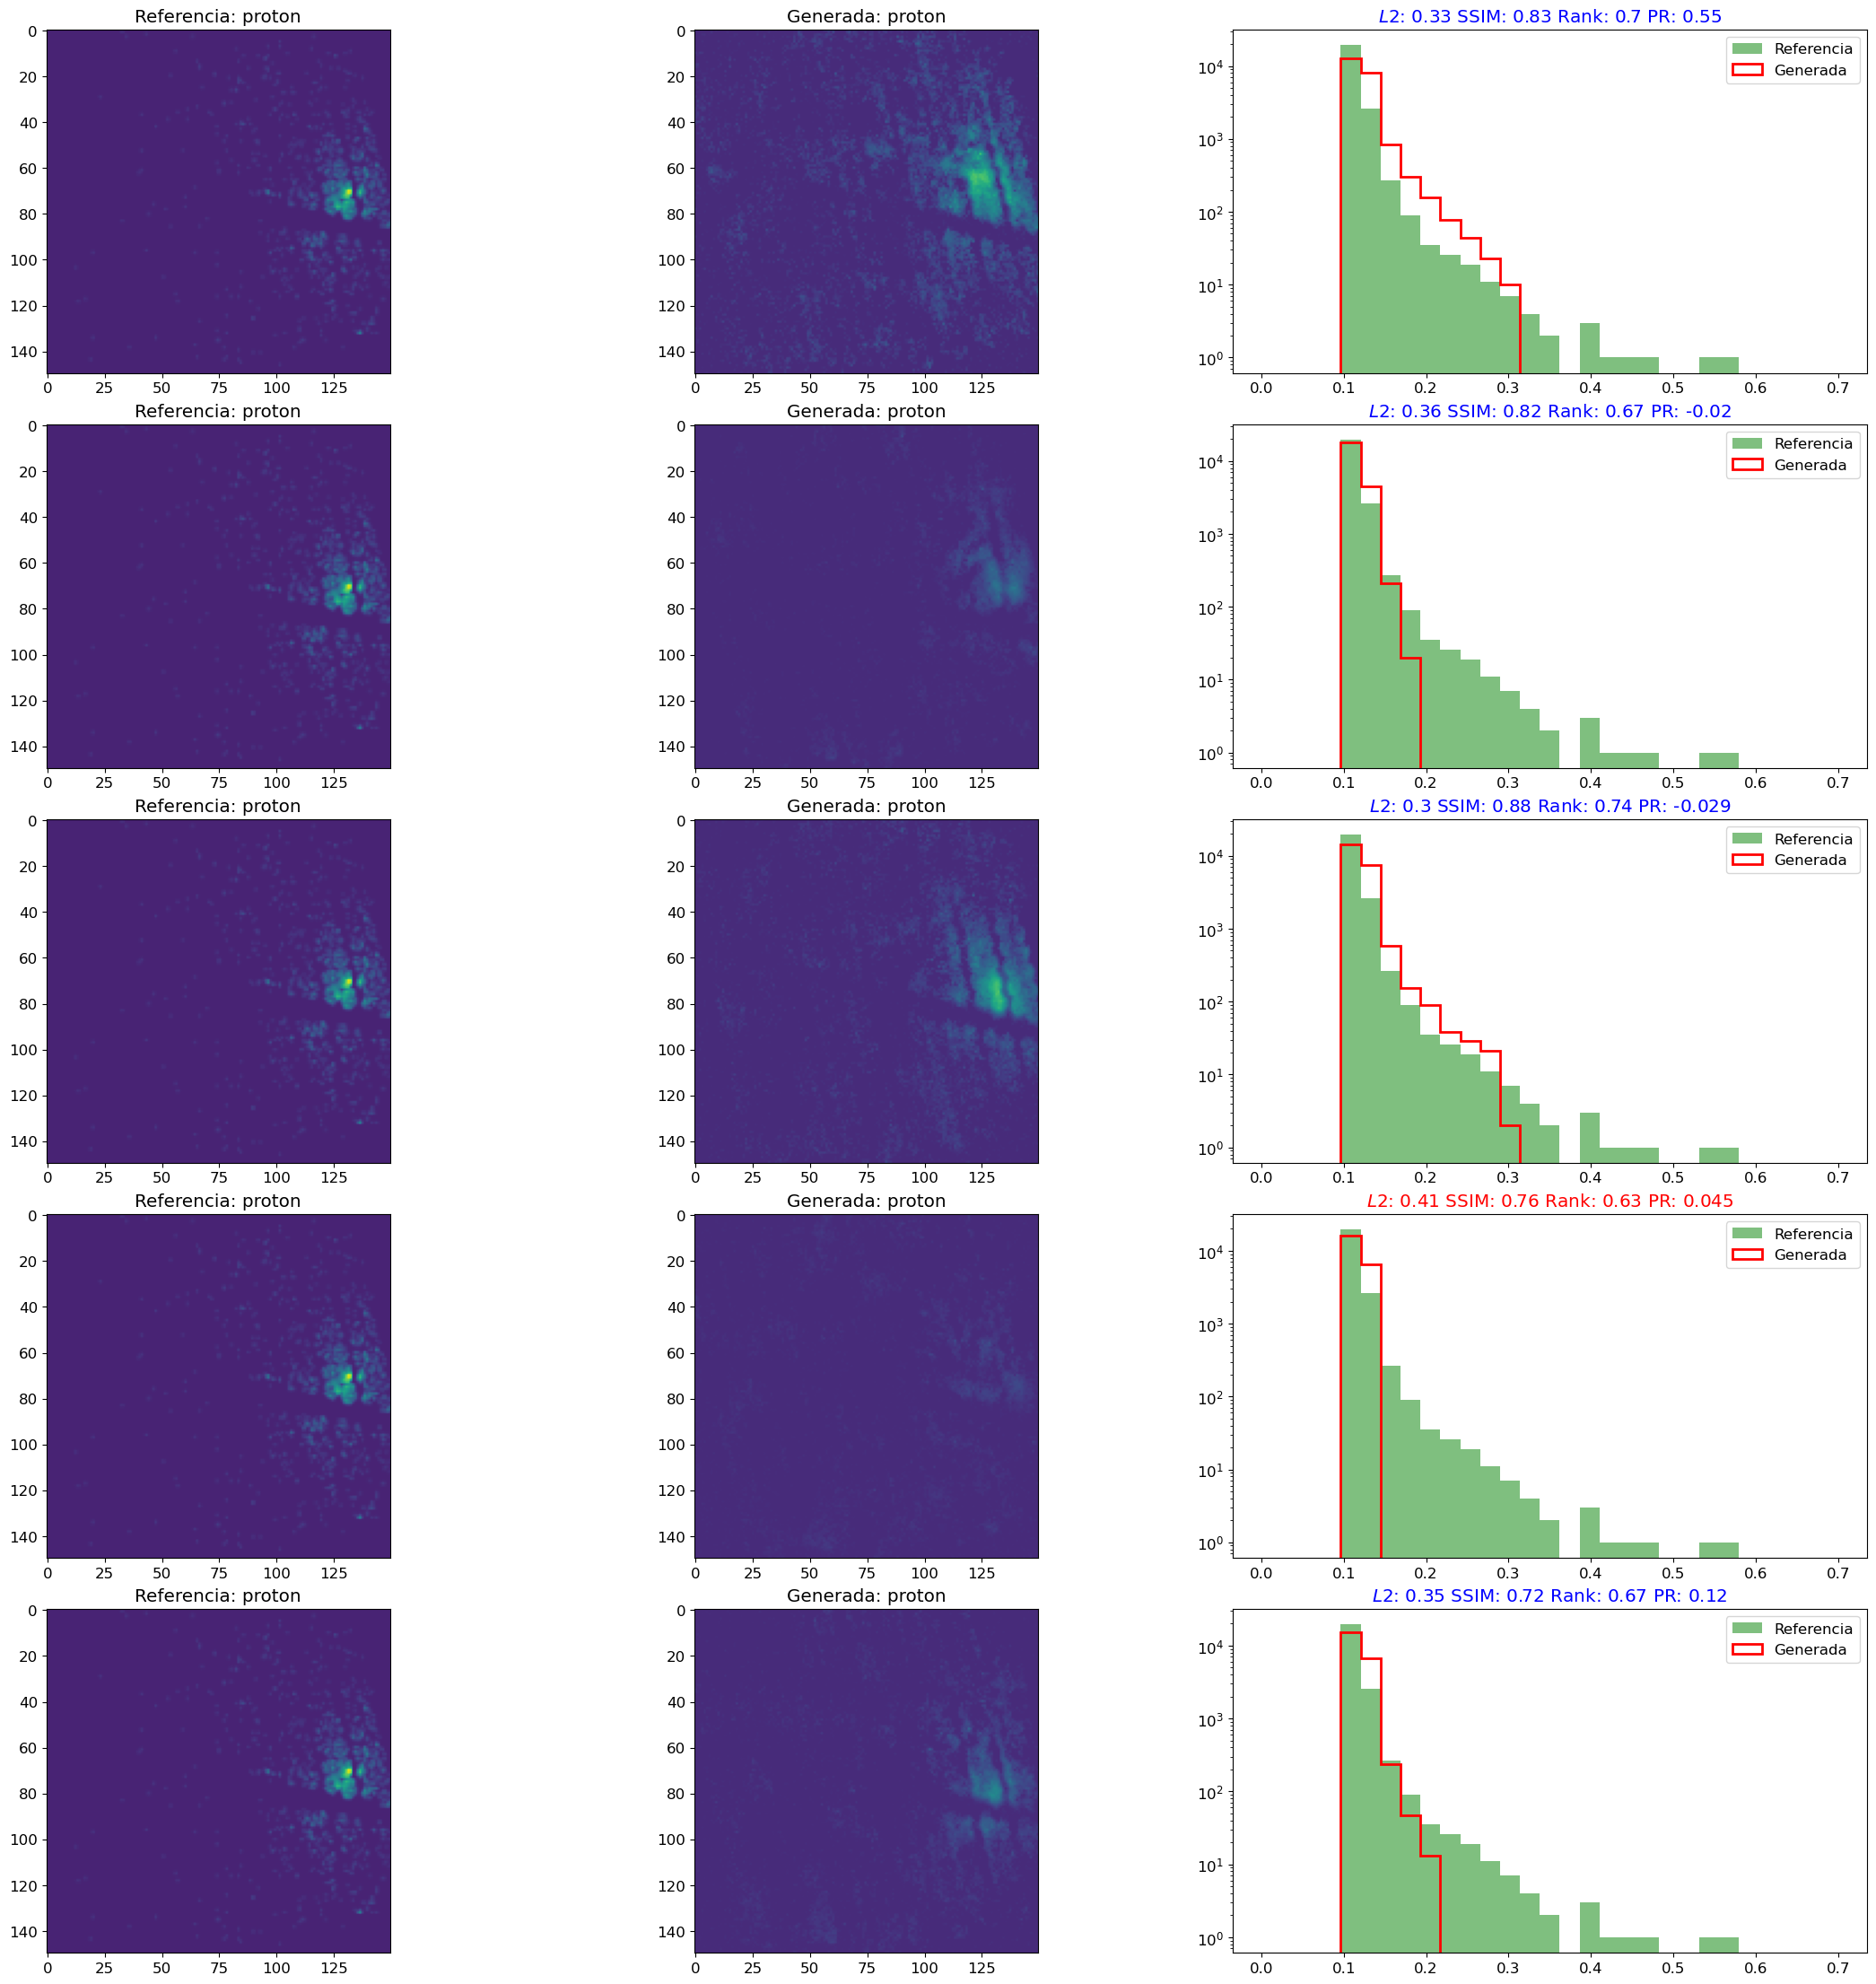

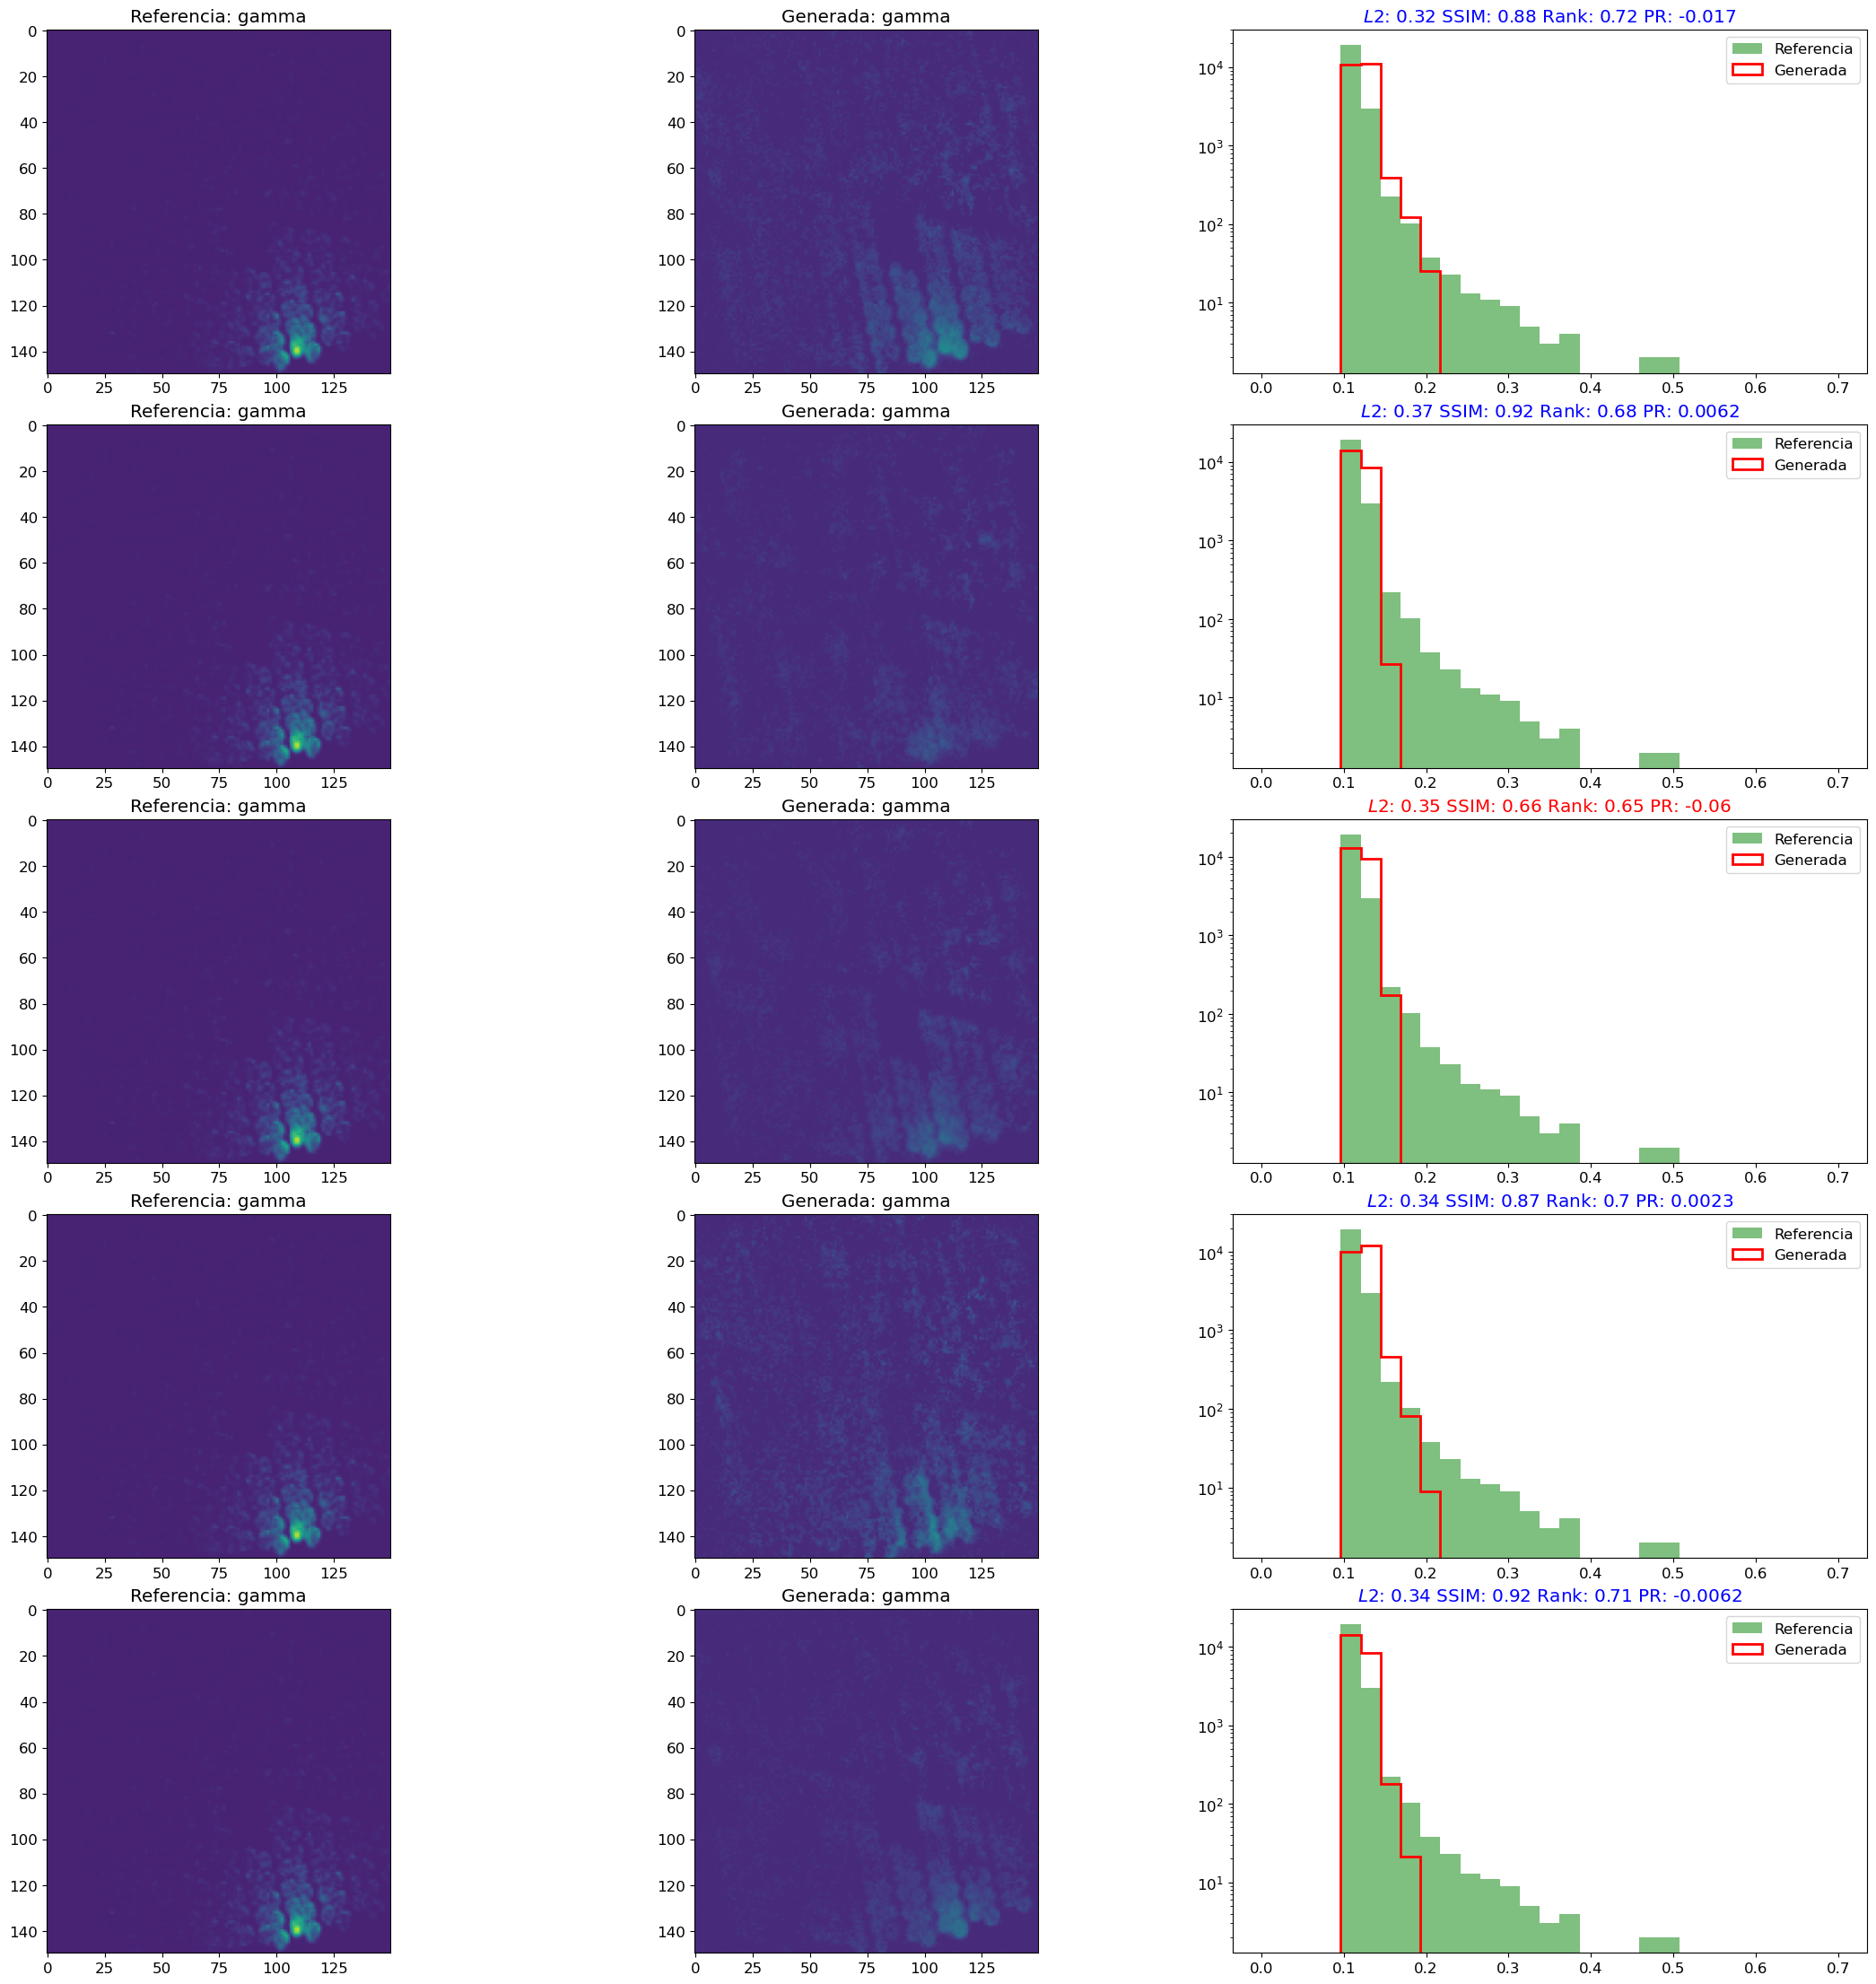

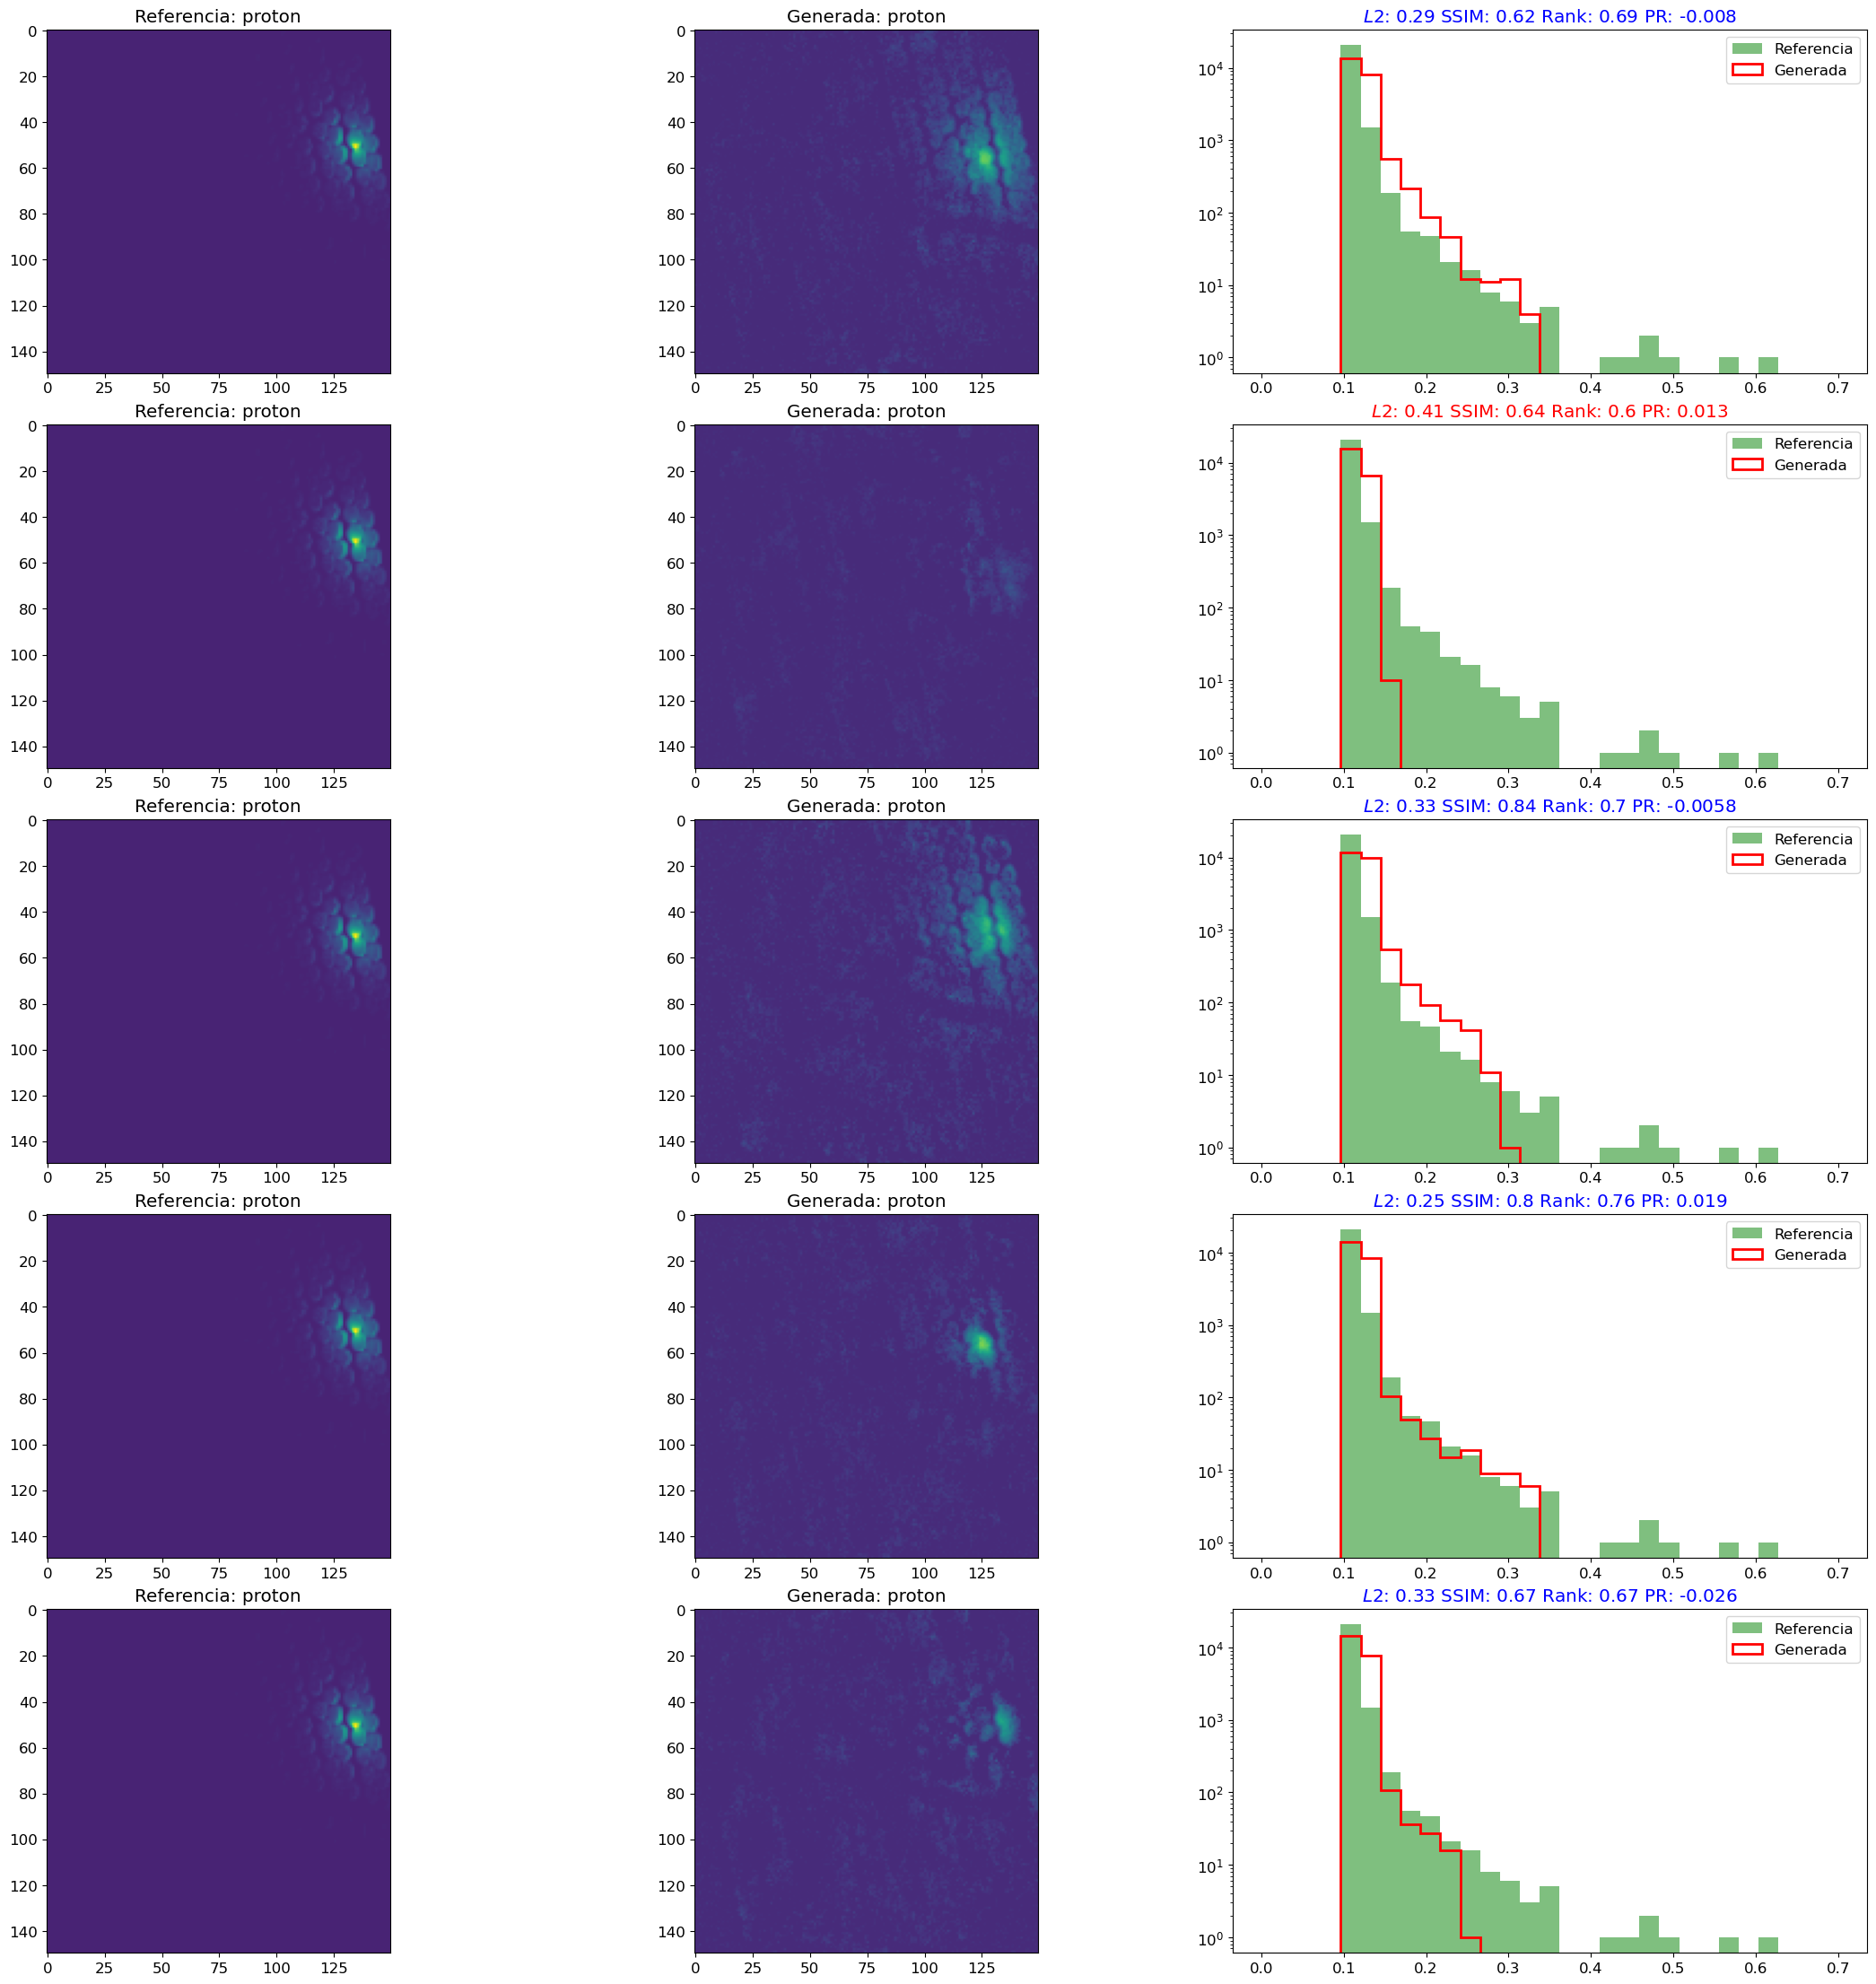

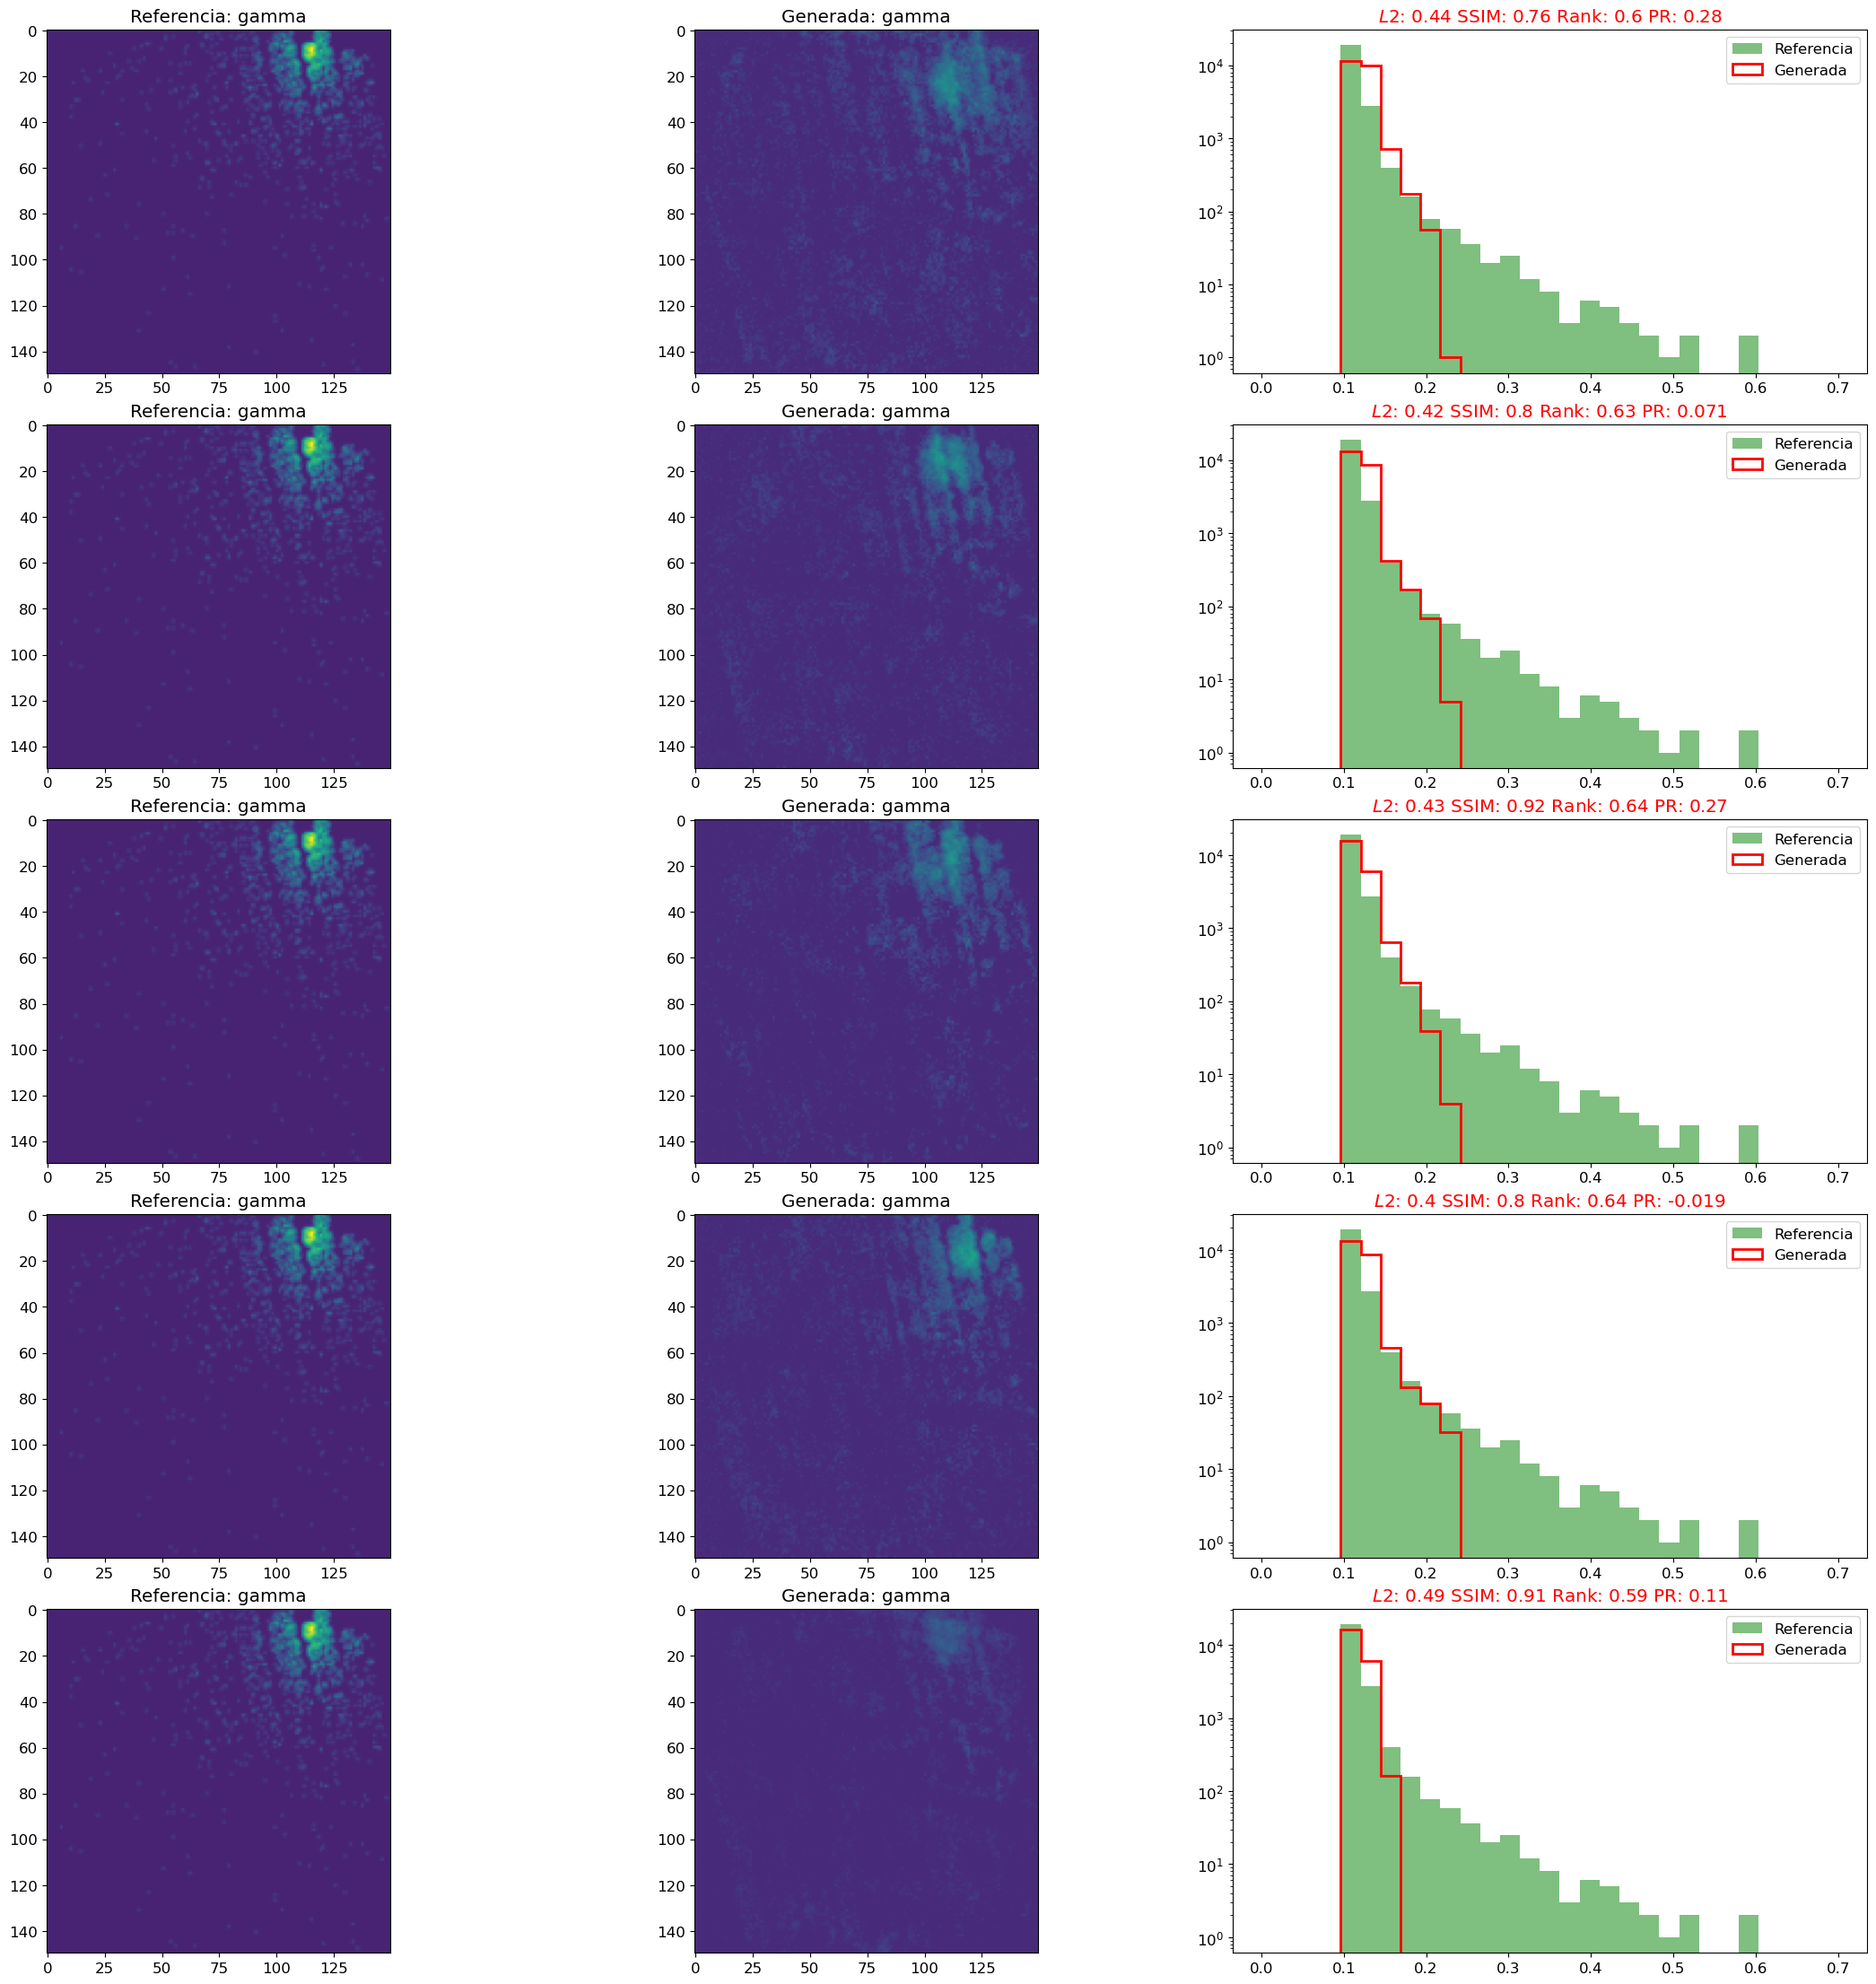

In [94]:
from scipy.stats import chisquare
plt.rcParams['text.usetex']=False
plt.ion()
plt.rcParams.update({'font.size':12})
reference = 4
samples = 5 

for i, (imgs, labels, paths) in enumerate(test_dataloader):
        batch_size = imgs.shape[0]
        reference = int(batch_size*0.1)

        label=labels[reference].clone()
        labels_reference=labels.clone()

        for j in range(len(labels)):
            labels_reference[j]=label
        
        np_meta = np.array([])
        
        for path in paths:
            path=path.replace('hawc_image','hawc_meta').replace('.png','.csv')
            if os.path.isfile(path):
                metadf = pd.read_csv(path)
                
                metadf['HAWCSim.Evt.Energy/F/0']=metadf['HAWCSim.Evt.Energy/F/0']/MaxEnergy['proton']
                metadf['HAWCSim.Evt.X/F/0.01']=metadf['HAWCSim.Evt.X/F/0.01']/MaxXY['X']
                metadf['HAWCSim.Evt.Y/F/0.01']=metadf['HAWCSim.Evt.Y/F/0.01']/MaxXY['Y']
                metadf['HAWCSim.Evt.NMax/F/0.001']=metadf['HAWCSim.Evt.NMax/F/0.001']/MaxN['proton']
                metadf['HAWCSim.Evt.Theta/F/0.001']=metadf['HAWCSim.Evt.Theta/F/0.001']/MaxTheta['proton']
                metadf['HAWCSim.Evt.Phi/F/0.001']=metadf['HAWCSim.Evt.Phi/F/0.001']/MaxPhi['proton']
                np_meta= np.append(np_meta,metadf.to_numpy())
                
                del metadf
            else:
                np_meta= np.append(np_meta,[0.,0.,0.,0.,0.,0.])
                print ('no metadata')
                
        np_meta_reference = np.array([])

        for ii in range(batch_size):
            if ii<reference:
                np_meta_reference = np.append(np_meta_reference,np_meta[reference*6:reference*6+6].copy())
            else:
                np_meta_reference = np.append(np_meta_reference,np_meta[ii*6:ii*6+6].copy())

        optimizer_G.zero_grad()

        z = Variable(FloatTensor(np.random.normal(0, 1, (batch_size, latent_dim))))
        z = Variable(FloatTensor(np.random.normal(0, 1, (batch_size, latent_dim))))
  
        gen_labels = Variable(torch.cat(
                          (labels_reference.type(LongTensor).reshape(batch_size,1),
                           FloatTensor(np_meta_reference).reshape(batch_size,n_conditions-1)),
                           1))

        gen_imgs = generator(z, gen_labels)

        fig,axes = plt.subplots(nrows=samples,ncols=3,figsize=(22,22),constrained_layout=True)
        
        for idx in range(samples):
            generated_samples = gen_imgs.detach()[idx,0].clone()
            
            generated_samples = generated_samples.to('cpu')
            
            plot=(generated_samples.numpy()).reshape(150*150)
            plot=np.array([ plot[i] if plot[i]>=0.12 else 0.12 for i in range(150*150) ]).reshape([150,150])
            
            if gen_labels[idx][0]==0:
                particle = 'gamma'
            else:
                particle = 'proton'

            alpha=1.0
            #Visualizamos la imagen generada
            axes[idx,1].imshow(np.abs(plot)*alpha, norm='log', origin='upper', vmin=0.1, vmax=0.45) 
            axes[idx,1].set_title(f'Generada: {particle}')

            # Comparamos con la imagen de entrenamiento
            if labels_reference[idx]==0:
                particle = 'gamma'
            else:
                particle = 'proton'
            
            axes[idx,0].imshow(np.abs(imgs.numpy()[reference][0]),  norm='log', origin='upper', vmin=0.1,vmax=0.6)
            axes[idx,0].set_title(f'Referencia: {particle}')

            BINS=30
            bins=np.linspace(0,0.7,BINS)
            countsRef,binsRef=np.histogram(imgs.numpy()[reference][0].reshape(150*150),bins=bins)
            countsGen,binsGen=np.histogram(plot.reshape(150*150)*alpha,bins=bins)
            
            axes[idx,2].hist(binsRef[:-1],binsRef,weights=countsRef,log=True,label='Referencia',color='g',alpha=0.5)
            axes[idx,2].hist(binsGen[:-1],binsGen,weights=countsGen,log=True,histtype='step',stacked=True,label='Generada',color='r',linewidth=2)

            
            img_np = np.abs(imgs.numpy()[idx][0])
            simage = ssim(plot,img_np,data_range=img_np.max()-img_np.min())
            mse = mean_squared_error (plot,img_np)
            chi2,p_value= cs(countsGen+1,countsRef+1)
            L2=np.sum(np.abs(countsGen-countsRef)/np.abs(np.maximum(countsGen,countsRef)+1))/BINS
            
            s=f'{L2:0.2}'

            rank=(1-L2)*0.8+simage*0.2

            corrCoef, p_value = pearsonr(np.abs(img_np.reshape(150*150)), 
                                         np.abs(plot.reshape(150*150)))
            
            if rank>=0.65:    
                axes[idx,2].set_title(f'$L2$: '+s+f' SSIM: {simage:0.2} Rank: {rank:0.2} PR: {corrCoef:0.2}',color='b')
            else:
                axes[idx,2].set_title(f'$L2$: '+s+f' SSIM: {simage:0.2} Rank: {rank:0.2} PR: {corrCoef:0.2}',color='r')            
            
            
            axes[idx,2].legend(loc='upper right')
        if i==4:
            break


In [ ]:
plt.ioff()
plt.rcParams.update({'font.size':6})
samples=8
for i, (imgs, labels, paths) in enumerate(test_dataloader):

        batch_size = imgs.shape[0]
    
        np_meta = np.array([])
        for path in paths:
            path=path.replace('hawc_image','hawc_meta').replace('.png','.csv')
            if os.path.isfile(path):
                metadf = pd.read_csv(path)
                metadf['HAWCSim.Evt.Energy/F/0']=metadf['HAWCSim.Evt.Energy/F/0']/MaxEnergy['proton']
                metadf['HAWCSim.Evt.X/F/0.01']=metadf['HAWCSim.Evt.X/F/0.01']/MaxXY['X']
                metadf['HAWCSim.Evt.Y/F/0.01']=metadf['HAWCSim.Evt.Y/F/0.01']/MaxXY['Y']
                metadf['HAWCSim.Evt.NMax/F/0.001']=metadf['HAWCSim.Evt.NMax/F/0.001']/MaxN['proton']
                metadf['HAWCSim.Evt.Theta/F/0.001']=metadf['HAWCSim.Evt.Theta/F/0.001']/MaxTheta['proton']
                metadf['HAWCSim.Evt.Phi/F/0.001']=metadf['HAWCSim.Evt.Phi/F/0.001']/MaxPhi['proton']
                np_meta= np.append(np_meta,metadf.to_numpy())
                del metadf
            else:
                np_meta= np.append(np_meta,[0.,0.,0.,0.,0.,0.])
                
        # Sample noise and labels as generator input
        optimizer_G.zero_grad()
    
        z = Variable(FloatTensor(np.random.normal(0, 1, (batch_size, latent_dim))))

        # Tratamos de generar una respuesta similar al entrenamiento
        gen_labels = Variable(torch.cat(
                          (labels.type(LongTensor).reshape(batch_size,1),
                           FloatTensor(np_meta).reshape(batch_size,n_conditions-1)),
                           1))
        
        gen_imgs = generator(z, gen_labels)

        fig = plt.figure(figsize=(7,21))

    
        #for idx in range(int(gen_imgs.shape[0]/14)): #gen_imgs.shape[0]):
        for idx in range(samples): #gen_imgs.shape[0]):
            generated_samples = gen_imgs.detach()[idx,0]
            #generated_samples = generated_samples.to(device='cpu')
            generated_samples = generated_samples.to('cpu')
            plot=(generated_samples.numpy())

            # Comparamos con la imagen de entrenamiento
            if labels[idx]==0:
                particle = 'gamma'
            else:
                particle = 'proton'

            #fig.add_subplot(int(np.ceil(batch_size*2)), 2, 1+(idx*2)+1)
            fig.add_subplot(samples, 3, 1+(idx*3))
            #plt.imshow(imgs.numpy()[idx][0],  origin='upper', norm='linear', vmin=0.16, vmax=1.0)
            plt.imshow(np.abs(imgs.numpy()[idx][0]),  norm='log', origin='upper', vmin=0.1,vmax=0.8) #, vmin=0.15, vmax=0.4)
            plt.title(f'Referencia: {particle}')
            
            if gen_labels[idx][0]==0:
                particle = 'gamma'
            else:
                particle = 'proton'

            alpha=1.0
            #Visualizamos la imagen generada
            #fig.add_subplot(int(np.ceil(batch_size*2)), 2, 1+idx*2)
            fig.add_subplot(samples, 3, 1+(idx*3)+1)
            plt.imshow(np.abs(plot)*alpha, norm='log', origin='upper', vmin=0.1)
            #plt.imshow(plot,  origin='upper')
            plt.title(f'Generada: {particle}')

            #fig.add_subplot(int(np.ceil(batch_size*2)), 2, 1+(idx*2)+1)
            fig.add_subplot(samples, 3, 1+(idx*3)+2)
            #plt.imshow(imgs.numpy()[idx][0],  origin='upper', norm='linear', vmin=0.16, vmax=1.0)
            error_plot=np.abs(plot*alpha-imgs.numpy()[idx][0])
            plt.imshow(error_plot, origin='upper',vmin=0.0,vmax=0.8)
            mse= np.sqrt(np.square(np.subtract(plot.reshape(150*150),imgs.numpy()[idx][0].reshape(150*150))).mean())
            plt.title(f'MSE: {mse:0.4}')
        break

#bbox_inches=mpl.transforms.Bbox([[1.5, 0.55 ], [10, 20.05]])  
image_path=f'output/conjunto_prueba_4000gen.png'   
fig.savefig(image_path, dpi=120) #, bbox_inches=bbox_inches)
mpl.pyplot.close()